<a href="https://colab.research.google.com/github/parralleon/skill_test/blob/main/JR_Data_Scientist_Skill_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **JR Data Scientist - Skill Test**

You are being provided with the Telco Customer Churn data (https://www.kaggle.com/blastchar/telco-customer-churn) from the Kaggle IBM Sample Datasets. You are required to: 
- Create a Python model to predict customer churn.
- Propose 5 client retention programs to increase engagement.



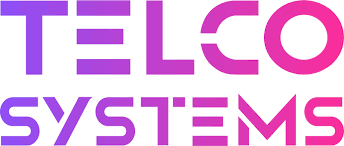

# **1. Loading required libraries**

In [295]:
# Importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from scipy.stats import chi2_contingency
from scipy.stats import t

# For preprocessing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

# For model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# **2. Data**

## **2.1 Loading the data**

In [296]:
# Loading the dataset directly from GitHub
url = 'https://raw.githubusercontent.com/parralleon/skill_test/main/data/WA_Fn-UseC_-Telco-Customer-Churn.csv'
data = pd.read_csv(url)
# Printing out the first 3 customer's information in the dataset
data.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


## **2.2 Dataset description**

Each row represents a customer, each column contains customer’s attributes described on the column Metadata.

The data set includes information about**:

- **Customers who left within the last month:** the column is called Churn
- **Services that each customer has signed up for:** phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
- **Customer account information:** how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
- **Demographic info about customers:** gender, age, and if they have partners and dependents


The meaning of each columns is as follows:

- **customerID:** Customer ID.
- **gender:** Whether the customer is a male or a female.
- **SeniorCitizen:** Whether the customer is a senior citizen or not (1, 0).
- **Partner:** Whether the customer has a partner or not (Yes, No).
- **Dependents:** Whether the customer has dependents or not (Yes, No).
- **Tenure:** Number of months the customer has stayed with the company.
- **PhoneService:** Whether the customer has a phone service or not (Yes, No).
- **MultipleLines:** Whether the customer has multiple lines or not (Yes, No, No phone service).
- **InternetService:** Customer’s internet service provider (DSL, Fiber optic, No).
- **OnlineSecurity:** Whether the customer has online security or not (Yes, No, No internet service).
- **OnlineBackup:** Whether the customer has online backup or not (Yes, No, No internet service).
- **DeviceProtection:** Whether the customer has device protection or not (Yes, No, No internet service).
- **TechSupport:** Whether the customer has tech support or not (Yes, No, No internet service).
- **StreamingTV:** Whether the customer has streaming TV or not (Yes, No, No internet service).
- **StreamingMovies:** Whether the customer has streaming movies or not (Yes, No, No internet service).
- **Contract:** The contract term of the customer (Month-to-month, One year, Two year).
- **PaperlessBilling:** Whether the customer has paperless billing or not (Yes, No).
- **PaymentMethod:** The customer’s payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic)).
- **MonthlyCharges:** The amount charged to the customer monthly.
- **TotalCharges:** The total amount charged to the customer.
- **Churn:** Whether the customer churned or not (Yes or No).

** Information taken from the Kaggle.

## 2.3 Dataset summary

In [297]:
# Printing out a summary for the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


After having reviewed the report above, it can be seen that there are a total of 21 columns (features), and a total of 7043 entries (customers). No null values were found. However, by looking at the "Dtype" column, one can see some discrepancies.

- **Discrepancy 1:** Take for instance the type of data for the "TotalCharges" column, it is expected to be a numerical value (e.g., float64 dtype), however the report says that it is of an "object" type (Solution will be given next).

- **Discrepancy 2:** Something silimar happens for the "SeniorCitizen" column which shows a data type of "int64" (it takes values only on 1 or 0). For now (during the EDA) this column will be encoded to something more meaningful like a "Yes"(1) or "No"(0). 

### 2.3.1 Fixing discrepancy 1

Since we already know that there are no missing values, the second most probable thing for the column is that some values are missing but were input as blank spaces, the following code will check for that.

In [298]:
# In order to check if there are some blank spaces in the TotalCharges column we do the following
print('Number of records being a single blank space: ', data['TotalCharges'][data['TotalCharges'] == ' '].count())

Number of records being a single blank space:  11


A total of 11 records have the "TotalCharges" amount as a single blank space. In order to further inspect and understand why this is the case, let us print out those 11 customers.

In [299]:
# Printing customer data with blank space in the TotalCharges column
data[data['TotalCharges'] == ' ']

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


From the data above, one can notice that customers with a "tenure" equals to 0, i.e., less than a month do not have a valid "TotalCharges" value (the same holds for customers having a single blank space on "TotalCharges" to have a "tenure" of 0 months). Analyzing the context, a simple imputation on those values makes sense, i.e., "TotalCharges" records being single blank spaces would be replaced by a zero value 0, which in this context indicates that no amount has been charged to the customer because it has less than a month of tenure.

In [300]:
# Imputating the single blank space for the TotalCharges column
data.loc[data['TotalCharges'] == ' ', 'TotalCharges'] = 0

Just as a sanity check we do the same validation on all columns (specially for those were the data type should be of the "object" type), for single and double blank spaces.

In [301]:
# Checking 
for i in range(2):
  print(f'Number of records being {i + 1} blank space' + f's'*i + ':', data[data == ' ' * (i + 1)].count().sum())


Number of records being 1 blank space: 0
Number of records being 2 blank spaces: 0


Finally, the colum "TotalCharges" is casted to a "float64" dtype object.

In [302]:
# Casting TotalCharges to float64
data['TotalCharges'] = data['TotalCharges'].astype('float64')

### 2.3.2 Fixing discrepancy 2

Fixing this "discrepancy" is straightforward, and the following lines of code encodes the column values as follows:

- 1 ---> Yes
- 0 ---> No

In [303]:
# Enconding the values for the SeniorCitizen column
data.loc[data['SeniorCitizen'] == 1, 'SeniorCitizen'] = 'Yes'
data.loc[data['SeniorCitizen'] == 0, 'SeniorCitizen'] = 'No'

## 2.4 Descriptive statistics

### 2.4.1 For numeric columns

In [304]:
# Printing out descriptive statistics for numeric columns
data.describe().T

,count,mean,std,min,25%,50%,75%,max
tenure,7043.0,32.371149,24.559481,0.00,9.00,29.00,55.00,72.00
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.50,70.35,89.85,118.75
TotalCharges,7043.0,2279.734304,2266.794470,0.00,398.55,1394.55,3786.60,8684.80


### 2.4.2 For non-numeric columns

In [305]:
# Printing out descriptive statistics for object type columns
data.describe(include='object').T

,count,unique,top,freq
customerID,7043,7043,9351-HXDMR,1
gender,7043,2,Male,3555
SeniorCitizen,7043,2,No,5901
Partner,7043,2,No,3641
Dependents,7043,2,No,4933
PhoneService,7043,2,Yes,6361
MultipleLines,7043,3,No,3390
InternetService,7043,3,Fiber optic,3096
OnlineSecurity,7043,3,No,3498
OnlineBackup,7043,3,No,3088


From the report above, one can see that the "CustomerID" column has exactly the same number of unique values as the data has customers, i.e., no repeated customer or records are found within this dataset. However the "CustomerID" column is not of great use for the task at hand. In the next cell a new version of the dataset without such feature is created.

In [306]:
# Removing the CustomerID feature from the dataset
data = data.drop(columns='customerID')

Another thing worth taking a look is the unique values for each non-numeric variable (e.g., categorical variables). In the next piece of code a print out of the unique values for every column is given.

In [307]:
# Printing out unique values for non-numeric columns
for col in data:
  if data[col].dtype == 'O':
    print('{:<20s} {:<20s}'.format((col + ' ' + ((20 - len(col) - 2) * '-') + '>'), str([x for x in data[col].unique()])))
  else:
    pass

gender ------------> ['Female', 'Male']  
SeniorCitizen -----> ['No', 'Yes']       
Partner -----------> ['Yes', 'No']       
Dependents --------> ['No', 'Yes']       
PhoneService ------> ['No', 'Yes']       
MultipleLines -----> ['No phone service', 'No', 'Yes']
InternetService ---> ['DSL', 'Fiber optic', 'No']
OnlineSecurity ----> ['No', 'Yes', 'No internet service']
OnlineBackup ------> ['Yes', 'No', 'No internet service']
DeviceProtection --> ['No', 'Yes', 'No internet service']
TechSupport -------> ['No', 'Yes', 'No internet service']
StreamingTV -------> ['No', 'Yes', 'No internet service']
StreamingMovies ---> ['No', 'Yes', 'No internet service']
Contract ----------> ['Month-to-month', 'One year', 'Two year']
PaperlessBilling --> ['Yes', 'No']       
PaymentMethod -----> ['Electronic check', 'Mailed check', 'Bank transfer (automatic)', 'Credit card (automatic)']
Churn -------------> ['No', 'Yes']       


To make "PaymentMethod" unique values shorter, the text "(automatic)" will be removed from "Bank tranfer (automatic)" and "Credit card (automatic)". This is done just for plotting purposes. 

In [308]:
# Removing the "(automatic)" text from the values in the column PaymentMethod
data.loc[data['PaymentMethod'] == 'Bank transfer (automatic)', 'PaymentMethod'] = 'Bank transfer'
data.loc[data['PaymentMethod'] == 'Credit card (automatic)', 'PaymentMethod'] = 'Credit card'

At this point the data is ready for further graphical exploration.

# **3. Exploratory Data Analysis**

## 3.1 Graphical Univariate Analysis

### 3.1.1 Distribution Plots for Numeric variables (Continuous and discrete)

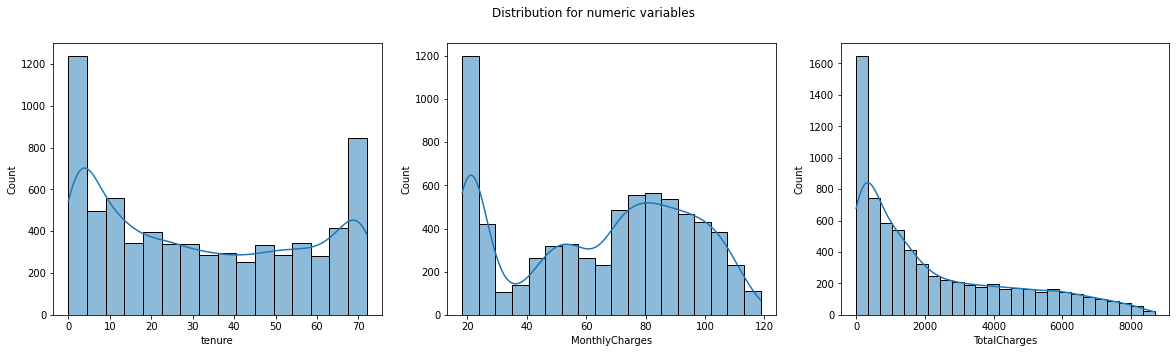

In [309]:
# Printing out the distribution of numeric variables
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
for i, feature in enumerate(data.select_dtypes(include=['float64', 'int64'])):
  sns.histplot(data=data, x=feature, kde=True, ax=axs[i])
fig.suptitle('Distribution for numeric variables')
plt.show()

The following information can be drawn from the plots above:
- By looking at the 'tenure' distribution, it is clear that it presents a bimodal distribution. Their two peaks are very apart from each other. One peak is around customers with a tenure less than 6 months, and the other peak starts to appear on customers with more than 60 months or so of tenure.

- By looking at the 'MonthlyCharges' distribution, one can see a multimodal distribution, it is easy to identify at least three different modes at around \$20, \$50 and \$80. These give us some information in regards of the different customer plans (bundles) that are most popular.

- 'TotalCharges' distribution is right skewed. The shape of this distribution is influenced by the 'MonthlyCharges' and the 'tenure' variable.

#### 3.1.1.1 Identifying customer type by contracted services 

There are a total of 9 features related with services that a customer can get. A list of such features is given next:

- **PhoneService:** No, Yes.       
- **MultipleLines:** No phone service, No, Yes.
- **InternetService:** DSL, Fiber optic, No.
- **OnlineSecurity:** No, Yes, No internet service.
- **OnlineBackup:** Yes, No, No internet service.
- **DeviceProtection:** No, Yes, No internet service.
- **TechSupport:** No, Yes, No internet service.
- **StreamingTV:** No, Yes, No internet service.
- **StreamingMovies:** No, Yes, No internet service.

From the above features and their values, there a total of $2*3^8 = 13,122$ different possible combinations, however not all of them are possible(e.g., a customer can not have "StreamingTV" without having "InternetService"). The code below computes the total number of different combinations found in the dataset.

In [310]:
# Computing the number of different combination choices for customers.
services = ['PhoneService',	'MultipleLines', 'InternetService',	'OnlineSecurity',	'OnlineBackup',	
            'DeviceProtection',	'TechSupport',	'StreamingTV',	'StreamingMovies']
# Computing unique values
bundles = data[services].drop_duplicates()
print(f'A total of {bundles.shape[0]} different bundles found in the dataset')

A total of 322 different bundles found in the dataset


A total of 322 different bundles are needed in order to construct the "MonthlyCharges" distribution shown in the subsection above. And modeling 322 distributions would not be practical nor informative. Instead a better approach would be to focus on those bundles with the most number of customers. In theory, such bundles would correspond to a peak in one of the distributions that formed the final "MonthlyCharges" multimodal distribution. I.e., such distribution is a mixture of some other nor or non-normal distributions.

In the code below, every bundle would be ranked accordingly to the number of customers having such configuration.

In [311]:
# Getting the number of customers assigned per bundle
bundles_customer_count = {}
for i in range(len(bundles)):
  bundles_customer_count[i] = data[(data[services] == bundles.iloc[i]).all(axis=1)].shape[0]

# Sorting (descending order) the indexes with the highest number of customers
sorted_indexes = sorted(bundles_customer_count.items(), key=lambda x: x[1], reverse=True)

# Printing out a report with the bundle features as well as its mean MonthCharges (The top 6 bundles are used for the report)
report_biggest_bundles = bundles.iloc[[x for x, y in sorted_indexes[:6]]].reset_index(drop=True)
monthly_charges_mean = []
for i in report_biggest_bundles.index:
  monthly_charges_mean.append(data[(data[services] == report_biggest_bundles.iloc[i]).all(axis=1)]['MonthlyCharges'].mean())
report_biggest_bundles.loc[:, 'meanMonthlyCharges'] = monthly_charges_mean
report_biggest_bundles

,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,meanMonthlyCharges
0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,19.955152
1,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,24.970614
2,Yes,No,Fiber optic,No,No,No,No,No,No,70.059442
3,Yes,No,DSL,No,No,No,No,No,No,44.963824
4,Yes,Yes,Fiber optic,No,No,No,No,No,No,74.910241
5,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,104.878309


With the table above (specially "meanMonthlyCharges" and their order of appeareance) and the original "MonthlyCharges" distribution presented before, one can start to understand the underlying pieces. Then clients can be grouped onto four different groups (some other number of groups could be used however, selection was made as to simplify the analysis). The groups are as follows:

- **Group_1:** Customers with "PhoneService = Yes", but no "InternetService".
- **Group_2:** Customers with "InternetService = DSL".
- **Group_3:** Customers with "InternetService = Fiber optic".
- **Group_4:** Customers with "StreamingTV = Yes" or "StreamingMovies == Yes".

One thing to note here is that features used as criteria to be part of a group are not mutually exclusive (except for Group_2 and Group_3), with this in mind, a customer in Group_4 can still have a "PhoneService = Yes". These four groups summarize the various bundles (322) found before.

Some cautions have to be taken in order to assign each customer to its respective Group number. The outer most groups are assigned first, i.e., the Group_1, then either Group_2 or Group_3 (since they are mutually exclusive in this feature), then, the Group_4 can be assigned. In each stage the group membership is being updated and overwritten as per the order selected. 

**Warning note:** If Group 4 is assigned before 2 or 3, then there will not be any customer that belongs to that group, it will be replaced by either Grupo_2 or Group_3.

In the following piece of code, the above details are implented in order to make the assignment.

In [313]:
# Creating a container to make the assignment
group_number = pd.Series(np.zeros(len(data)))

# Getting the indexes from the original dataset
g_1 = data[(data['PhoneService'] == 'Yes')]
g_2 = data[(data['InternetService'] == 'DSL')]
g_3 = data[(data['InternetService'] == 'Fiber optic')]
g_4 = data[(data['StreamingTV'] == 'Yes') & (data['StreamingMovies'] == 'Yes')]

# Assigning it to group series
group_number.iloc[g_1.index] = 'Group_1: Phone'
group_number.iloc[g_2.index] = 'Group_2: DSL'
group_number.iloc[g_3.index] = 'Group_3: Fiber'
group_number.iloc[g_4.index] = 'Group_4: Streaming'

# Adding the group_number column to a new dataset called data_grouped
data_grouped = data.copy(deep=True)
data_grouped['group_number'] = group_number

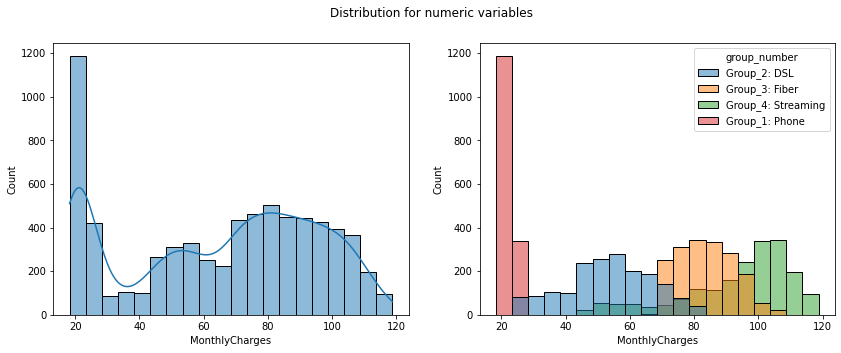

In [ ]:
# Plotting side-by-side the original MonthlyCharges distribution along with the grouped MonthlyCharges distribution.
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(data=data, x='MonthlyCharges', ax=axs[0], kde=True, bins=20)
sns.histplot(data=data_grouped, x='MonthlyCharges', ax=axs[1], hue='group_number', bins=20)
fig.suptitle('Distribution for numeric variables')
plt.show()

Now is clear that "MonthlyCharges" distribution is more or less a mixture of 4 different distributions that relates with the type of services(bundle) a customer have. The above segmentation would give more insights about the behavior towards churn of such groups. Proportions of these groups are shown below.

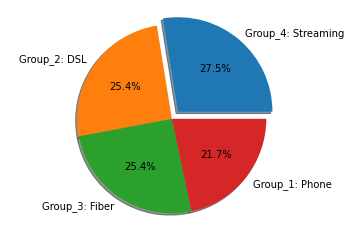

In [ ]:
# Pie chart
counts = data_grouped['group_number'].value_counts()
explode = (0.1, 0, 0, 0)
fig1, ax1 = plt.subplots()
ax1.pie(counts.values, explode=explode, labels=counts.keys(), autopct='%1.1f%%',
        shadow=True)
ax1.axis('equal')
plt.show()

Bundle types seem to be more or less balanced.

### 3.1.2 Count Plots for Categorical Variables

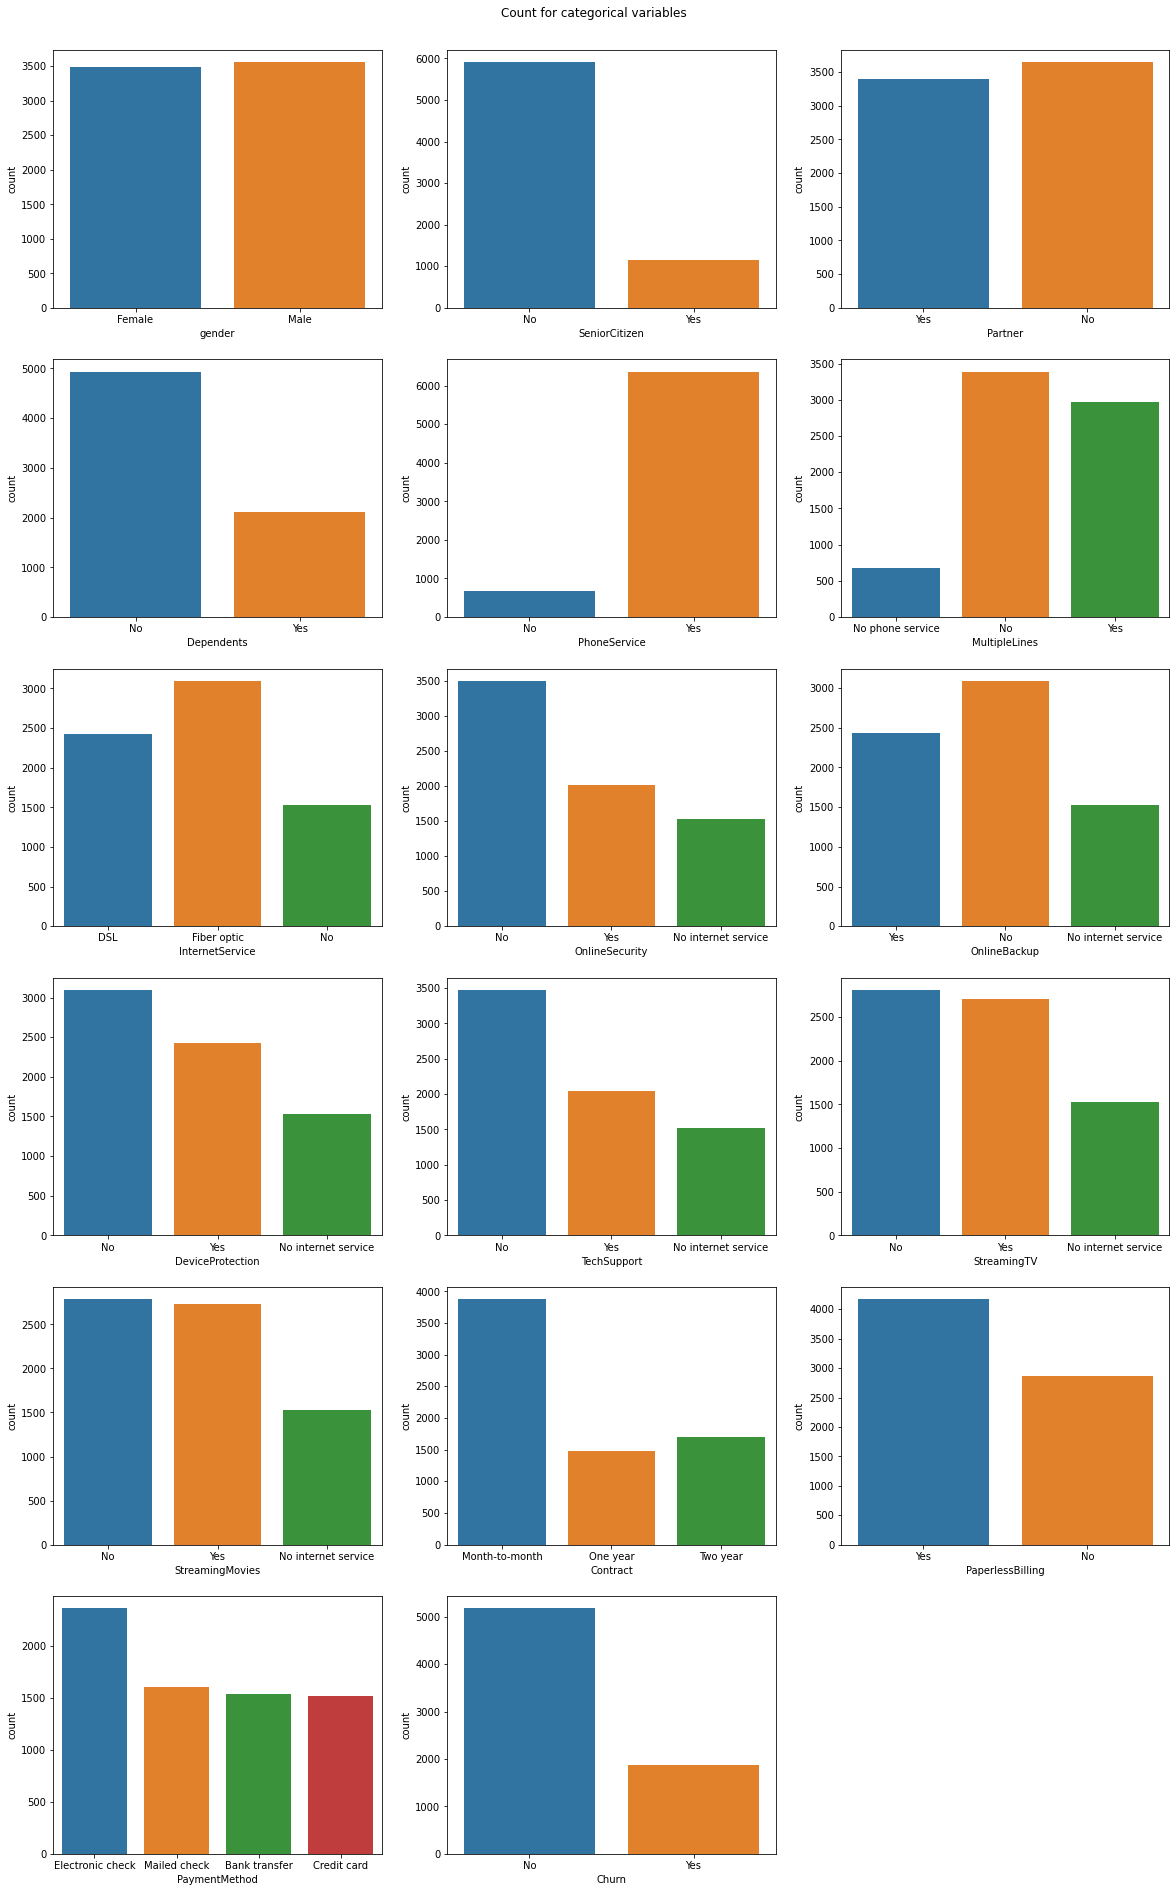

In [ ]:
# Creating a figure and a set of subplots
fig, axs = plt.subplots(6, 3, figsize=(20, 30))
fig.subplots_adjust(top=0.96)
# Flattening the axs for easier indexing
axs = axs.flatten()

for i, feature in enumerate(data.select_dtypes(include=['object'])):
  sns.countplot(data=data, x=feature, ax=axs[i])
fig.delaxes(axs[-1])
fig.suptitle('Count for categorical variables')
plt.show()

The above count plots give us a perspective about general demographic information of customers, most wanted services, methods of payment, etc. Below a brief summary of the most notable insights:

- There is a similar proportion of women and men.
- The vast majority of clients is under 65 years old.
- About 1/3 of customers have dependents.
- Almost all customers have at least a phone line on their plan.
- Around 20\% of the customers does not have internet. And for those who have the most popular extra services are StreamingTV and StreamingMovies. Less popular services are OnlineSecurity and TechSupport.
- Most customers prefer no physical billing and Electronic check as a method of payment, the rest of payment methods are equally popular.
- Customers tend to not compromise with long contracts. The Month-to-month plan is by far the most chosen one.
- There is a high proportion of customers leaving the company.

### 3.1.3 Box Plots for Numeric variables (Continuous and discrete)

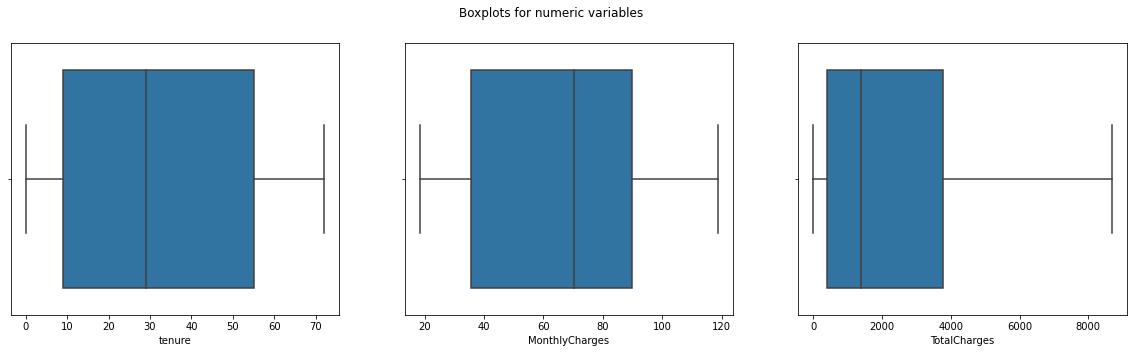

In [ ]:
# Printing out the distribution of numeric variables
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
for i, feature in enumerate(data.select_dtypes(include=['float64', 'int64'])):
  sns.boxplot(data=data, x=feature, ax=axs[i])
fig.suptitle('Boxplots for numeric variables')
plt.show()

From the boxplots above we can see that there are not outliers on these features. No need to remove any point.

## 3.2 Graphical Multivariate Analysis

### 3.2.1 Scatter Plots for Numeric variables (Continuous and discrete)

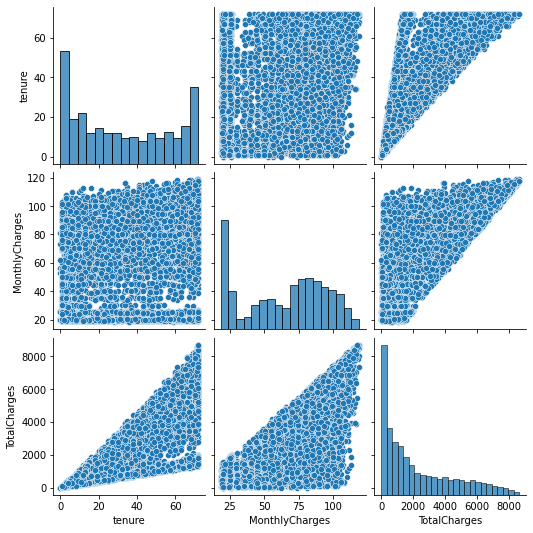

In [ ]:
# Plotting pairwise relationships in the data
sns.pairplot(data)
plt.show()

Looking at the pairwise scatter plots from above the following relationships can be drawn for each pair:

- **(tenure-MonthlyCharges):** No correlation.
- **(tenure-TotalCharges):** Positive correlation.
- **(MonthlyCharges-TotalCharges):** Positive correlation.

As expected, there is a positive correlation between the monthly charges of a customer and its tenure, and also the monthly charges and the total charges.

### 3.2.2 Distribution plots for tenure vs. categorical variables.

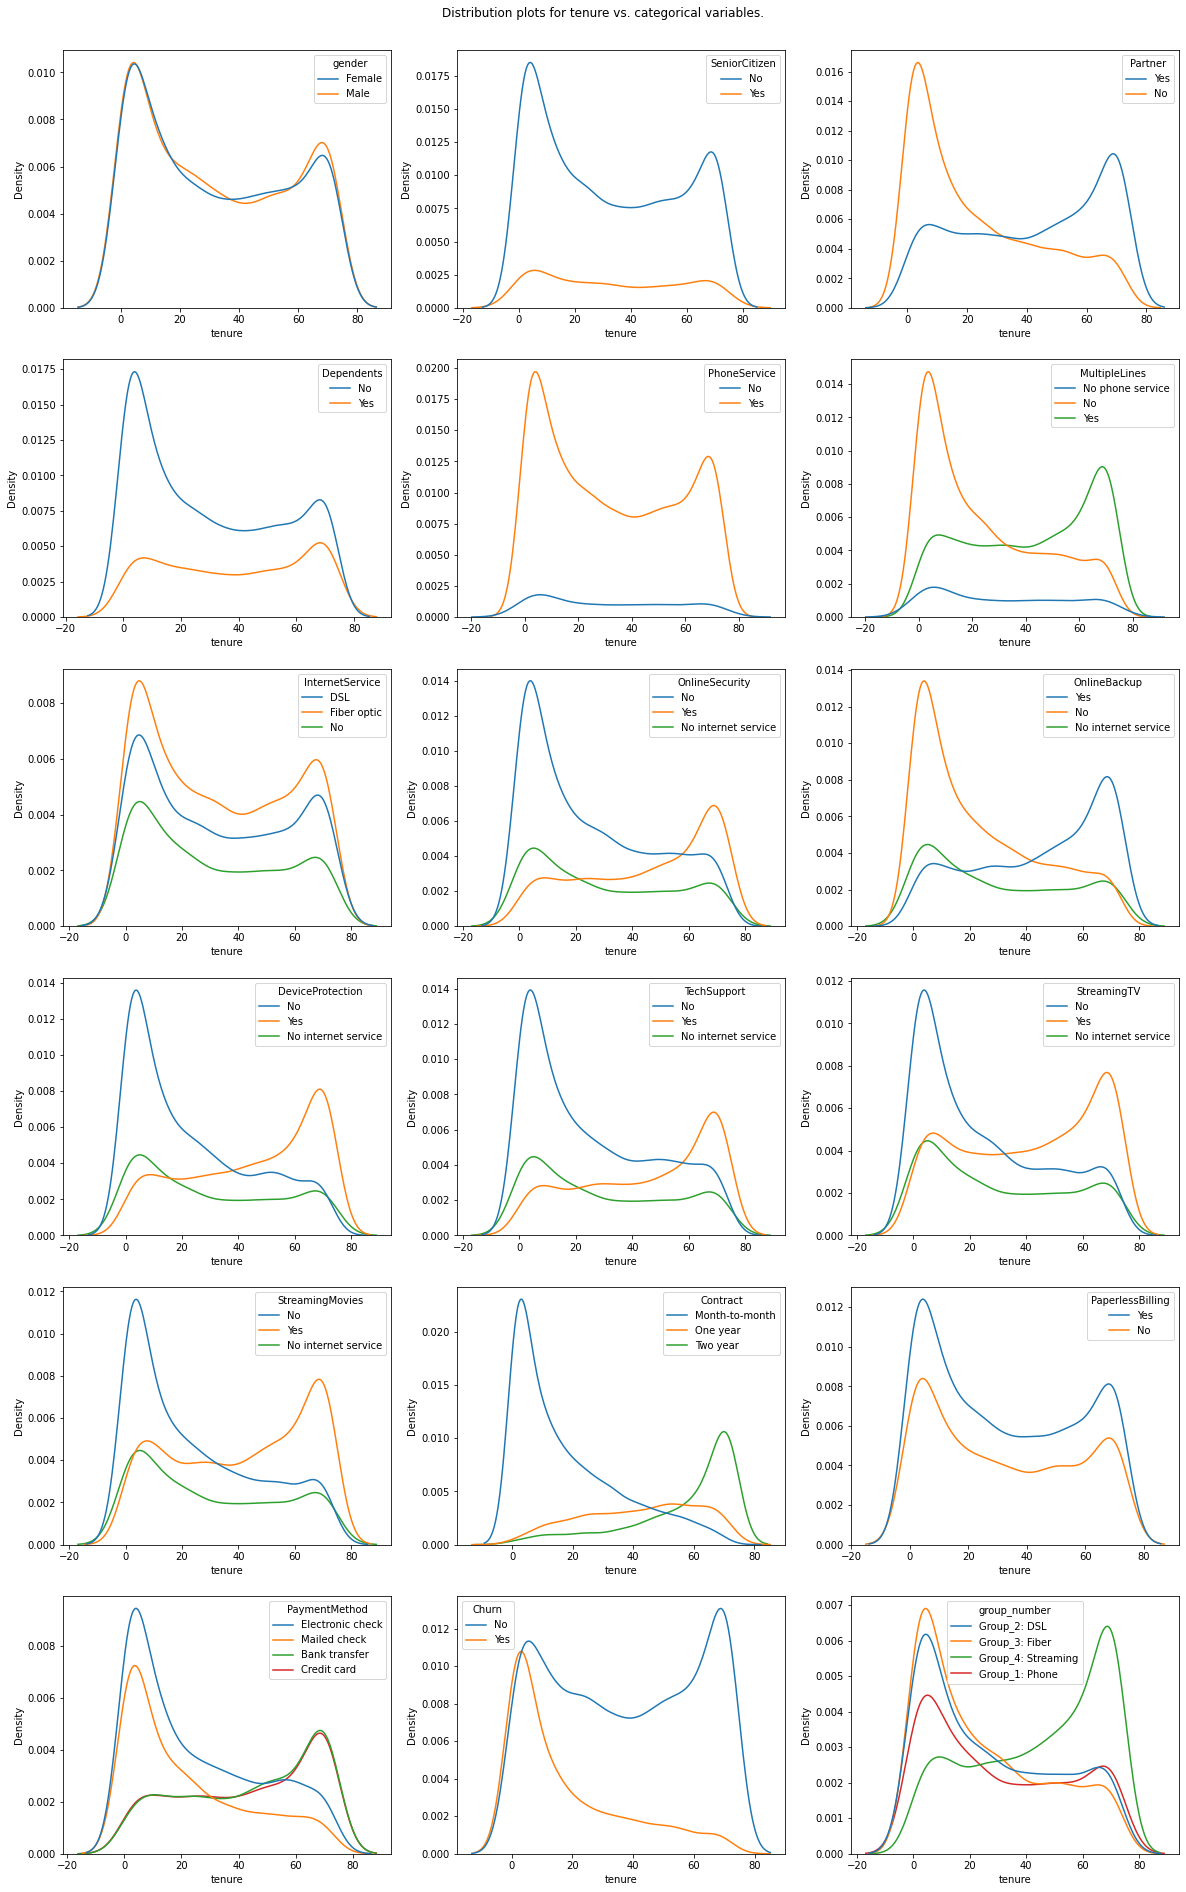

In [314]:
# Creating a figure and a set of subplots
fig, axs = plt.subplots(6, 3, figsize=(20, 30))
fig.subplots_adjust(top=0.96)
# Flattening the axs for easier indexing
axs = axs.flatten()

for i, feature in enumerate(data_grouped.select_dtypes(include=['object'])):
  sns.kdeplot(data=data_grouped, x='tenure', hue=feature, ax=axs[i])
# fig.delaxes(axs[-1])
fig.suptitle('Distribution plots for tenure vs. categorical variables.')
plt.show()

Observations:

- For almost all plots above, a clear patter can be spotted
- Customers with partner have a longer tenure. Most of the customers leave the company between 20 and 40 months of tenure.
- Streaming users have very different behavior than the rest of the groups, the distribution shape is just the opposite,i.e., most of these customers stay for the long run.
- The longer the customer stays with the company the less likely he will leave.
- Longer contracts like the two-year-contract is benefitial for customer commitment.
- Customers with automatic payment methods are less likely to leave at early stages.

### 3.2.3 Distribution plots for MonthlyCharges vs. categorical variables.

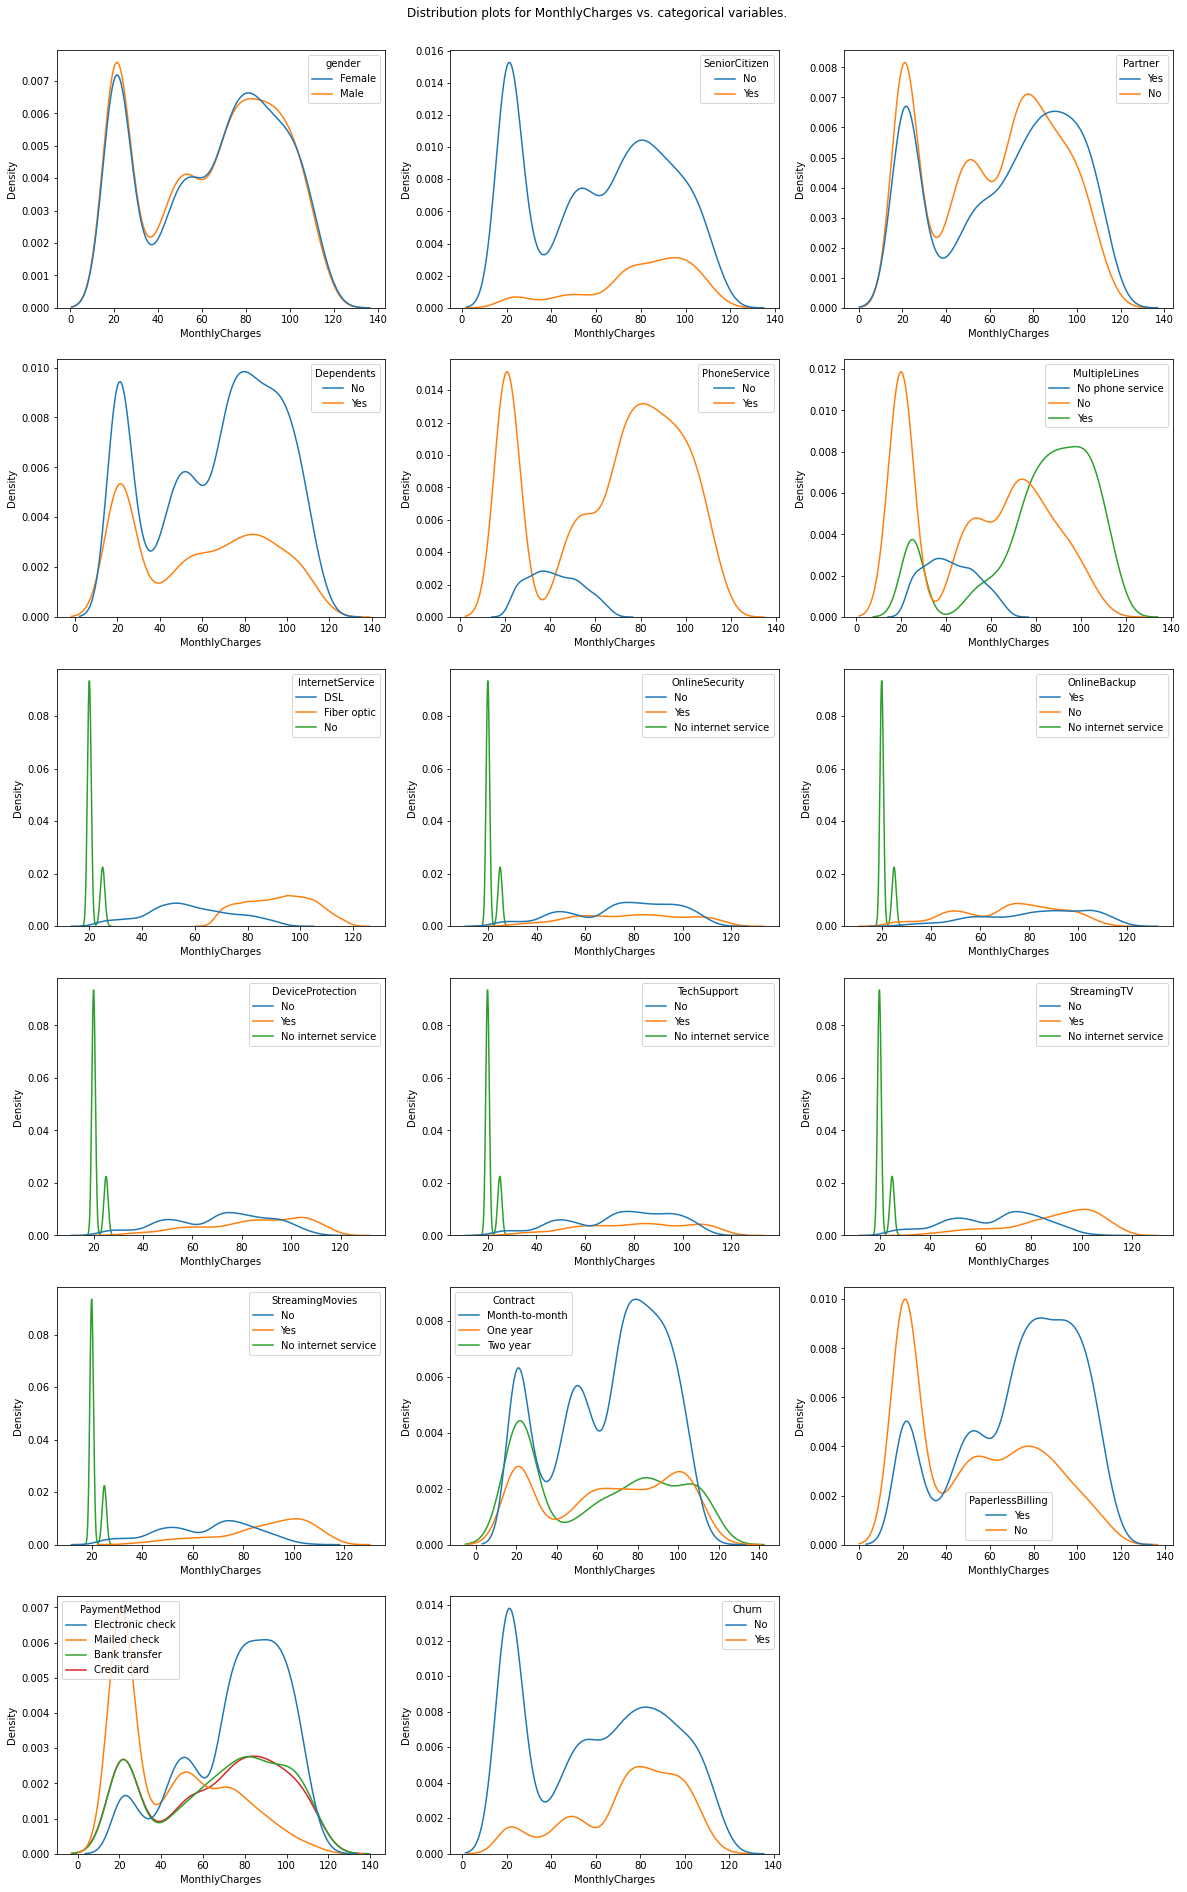

In [315]:
# Creating a figure and a set of subplots
fig, axs = plt.subplots(6, 3, figsize=(20, 30))
fig.subplots_adjust(top=0.96)
# Flattening the axs for easier indexing
axs = axs.flatten()

for i, feature in enumerate(data.select_dtypes(include=['object'])):
  sns.kdeplot(data=data, x='MonthlyCharges', hue=feature, ax=axs[i])
fig.delaxes(axs[-1])
fig.suptitle('Distribution plots for MonthlyCharges vs. categorical variables.')
plt.show()

Observations:

- Paperlessbilling can be associated with higher monthly charges.
- Most of the plots share the same shapes between the categories compared, this does not give us a clear pattern to get some information.

### 3.2.4 Distribution plots for TotalCharges vs. categorical variables.

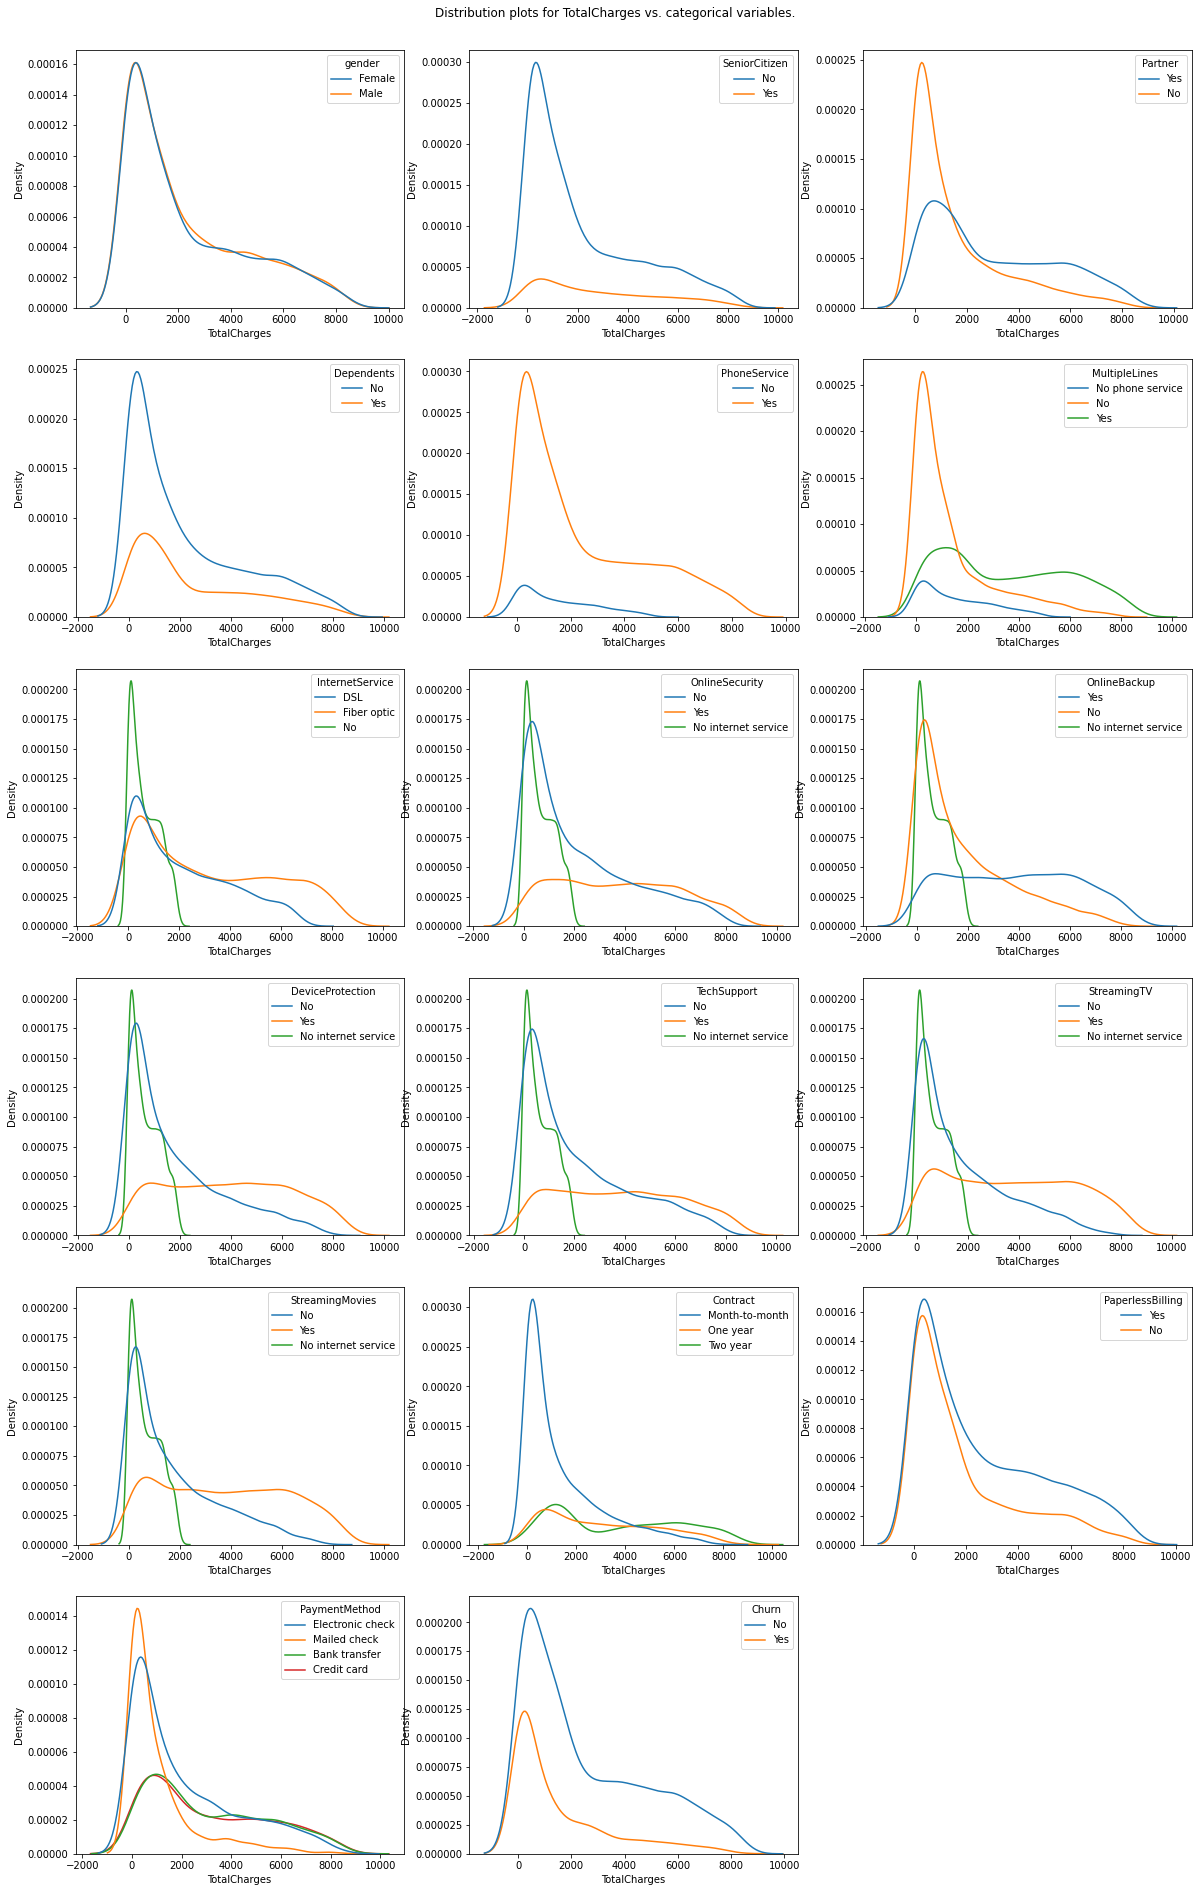

In [316]:
# Creating a figure and a set of subplots
fig, axs = plt.subplots(6, 3, figsize=(20, 30))
fig.subplots_adjust(top=0.96)
# Flattening the axs for easier indexing
axs = axs.flatten()

for i, feature in enumerate(data.select_dtypes(include=['object'])):
  sns.kdeplot(data=data_grouped, x='TotalCharges', hue=feature, ax=axs[i])
fig.delaxes(axs[-1])
fig.suptitle('Distribution plots for TotalCharges vs. categorical variables.')
plt.show()

### 3.2.4 Correlation.

Computing correlation between variables is a good practice in order to better understand the interactions within the data. By also incorporating the target label, you get a better perspective of which features are more importan for churn prediction.

Here, two different correlation procedures are to be followed. The first is focused on numerical variables and that uses pearson's correlation, and such approach is not suitable for categorical variables. For this reason it is better to use a correlation that works for nominal data (as most of the features we have). The Cramer's V correlation can be used for categorical variables.

#### 3.2.4.1 Pearson correlation for numeric features

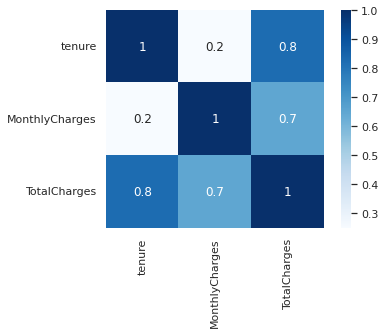

In [ ]:
# plt.figure(figsize=(14,8))
sns.set_theme(style="white")
corr = data.corr()
heatmap = sns.heatmap(corr, annot=True, cmap="Blues", fmt='.1g', square=True)

From the above correlation matrix, we can see the following:

- The 'tenure' and 'TotalCharges' are highly correlated (positively), this is something expected since both variables move together, i.e., the longer the tenure the higher the total charges paid till that point in time.

- 'MonthlyCharges' is naturally correlated with 'TotalCharges'.

- And the the last pair ('tenure - MonthlyCharges) is not as correlated as the rest, however its correlation is positive which indicates that customers are getting extra services as time goes on.

#### 3.2.4.2 Cramér's V correlation for categorical features

In [ ]:
# Corrected version of Cramer's V
def cramers_v(x, y): # Corrected version (wikipedia)
    confusion_matrix = pd.crosstab(x,y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [ ]:
# Function to compute the cramers_v_matrix
def cramers_v_matrix(data):

    cramers_v_results = []

    for feature_x in data.select_dtypes(include=['object']):
      temp_cramers_v_results = []
      for feature_y in data.select_dtypes(include=['object']):
        temp_cramers_v_results.append(cramers_v(data[feature_x], data[feature_y]))
      
      # Appending row to list
      cramers_v_results.append(temp_cramers_v_results)

    # Creating a pandas Dataframe with columns and indexes as the experiment_names
    cramers_v_matrix = pd.DataFrame(cramers_v_results, 
                                    columns=data.select_dtypes(include=['object']).columns, 
                                    index=data.select_dtypes(include=['object']).columns) 
 
    return cramers_v_matrix

In [ ]:
cra = cramers_v_matrix(data_grouped)

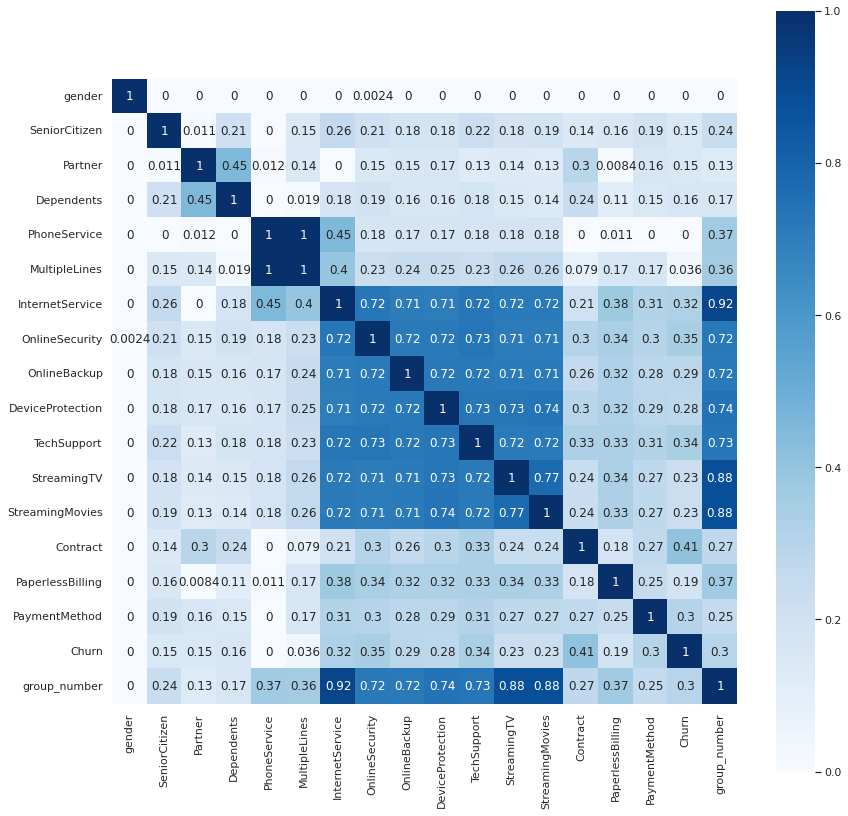

In [ ]:
plt.figure(figsize=(14, 14))
sns.set_theme(style="white")
heatmap = sns.heatmap(cra, annot=True, cmap="Blues", fmt='.2g', square=True)

From the above correlation matrix, we can see the following:

- All features related to services are highly correlated between them. The square at the center. One of the reasons is that some services are dependent on others (e.g., internet-streaming).
- With less degree of correlation we have Partner-Dependents.
- The type of contract has also notable correlation with the churn variable.
- The phone and multiple lines features are the less correlated with the churn variable, this gives us a hint that these two features can not be good predictors for customer churn.
- The gender variable seemed to have no correlation with any feature, this might be the less useful feature in our dataset.

### 3.2.6 Boxplots for tenure vs. categorical variables 

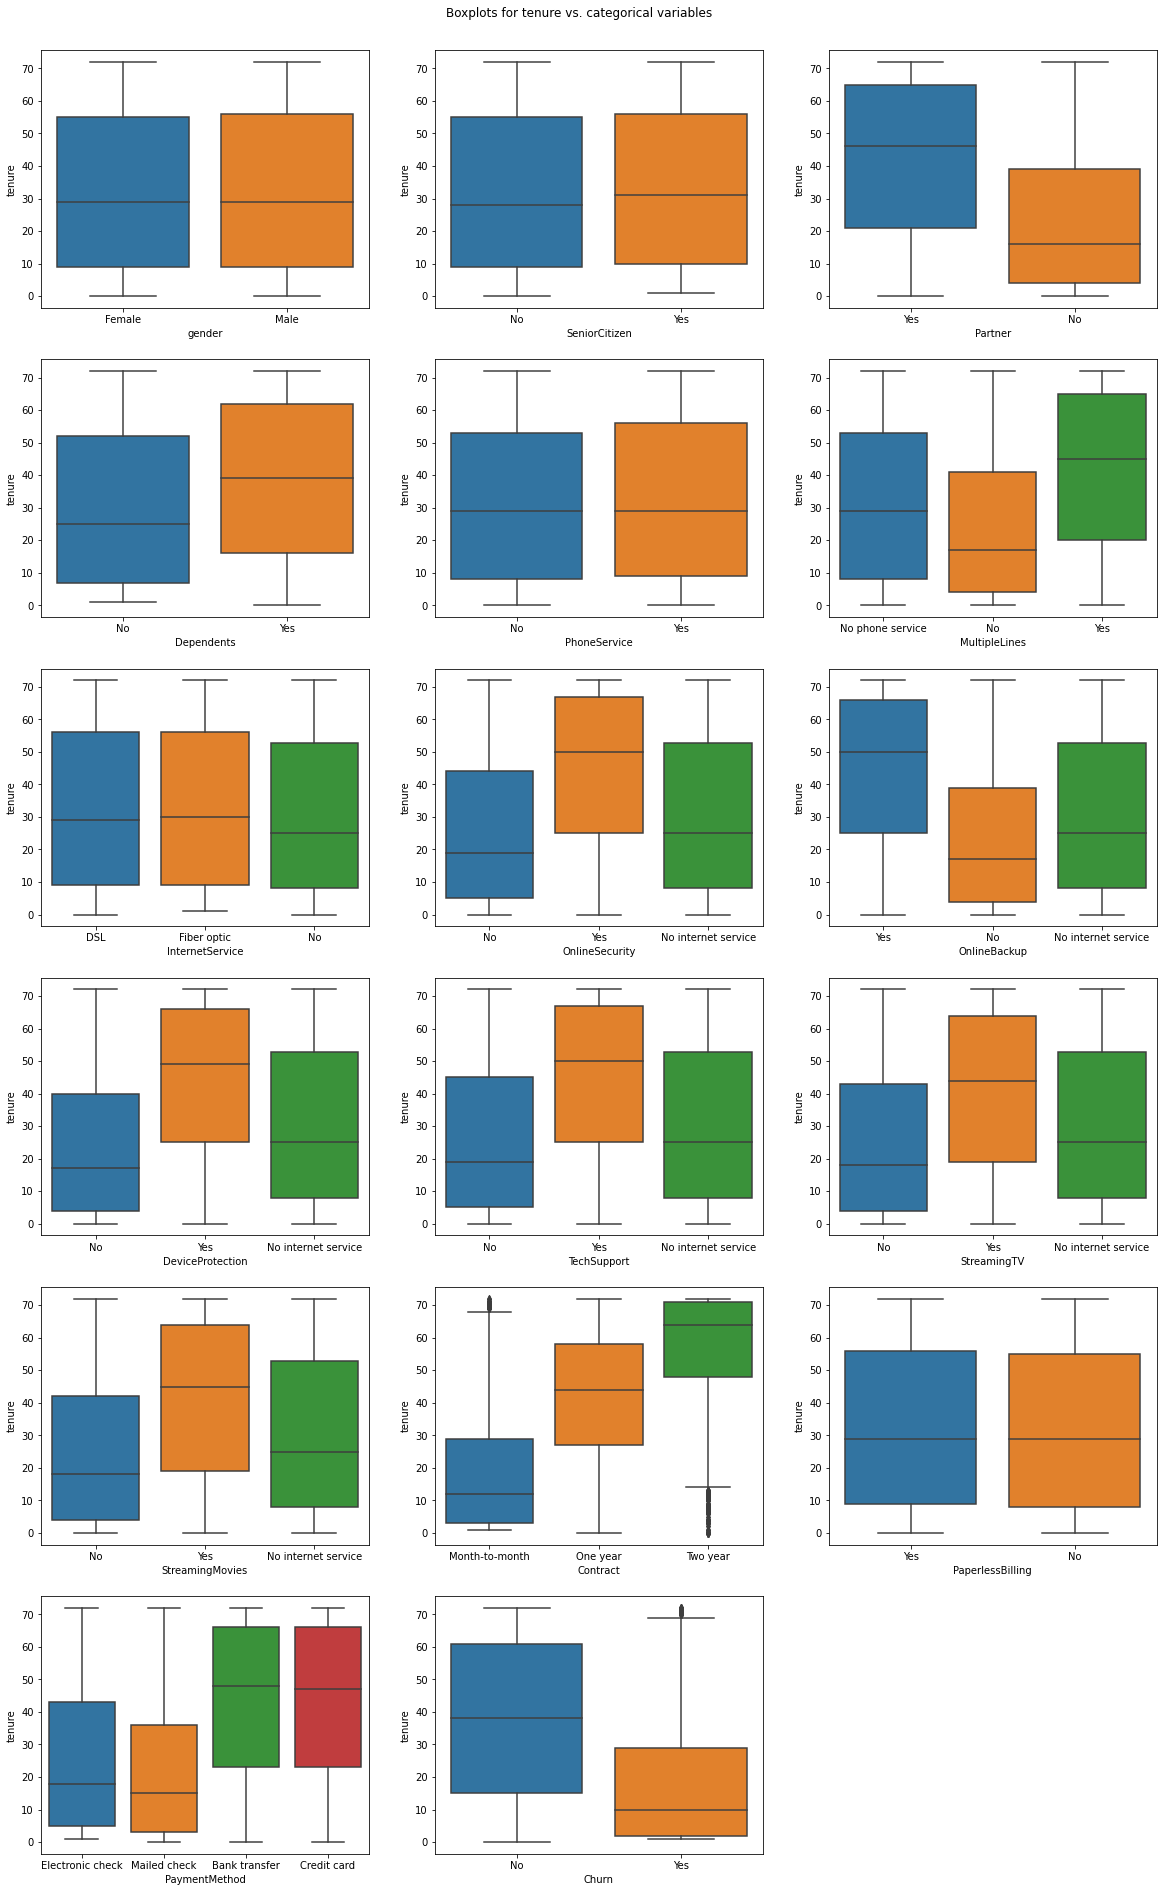

In [317]:
# Creating a figure and a set of subplots
fig, axs = plt.subplots(6, 3, figsize=(20, 30))
fig.subplots_adjust(top=0.96)
# Flattening the axs for easier indexing
axs = axs.flatten()

for i, feature in enumerate(data.select_dtypes(include=['object'])):
  sns.boxplot(data=data, x=feature, y='tenure', ax=axs[i])
fig.delaxes(axs[-1])
fig.suptitle('Boxplots for tenure vs. categorical variables ')
plt.show()

From the boxplots above, the most notable information is as follows:

- Customers that leave the company have a median of about 10 months, and some outliers are beyond the upper fence of about 70 months.
- The contract type plays a very importan role, for the "Two years" contract the median tenure is about 60 months, with very small dispersion.
- Automatic payment methods like "Bank transfer" and "Credit card" are associated with a greater ternure median (about 50 months for each case). The median for the rest of the payment methods are way below this value.

### 3.2.6 Boxplots for MonthlyCharges vs. categorical variables.

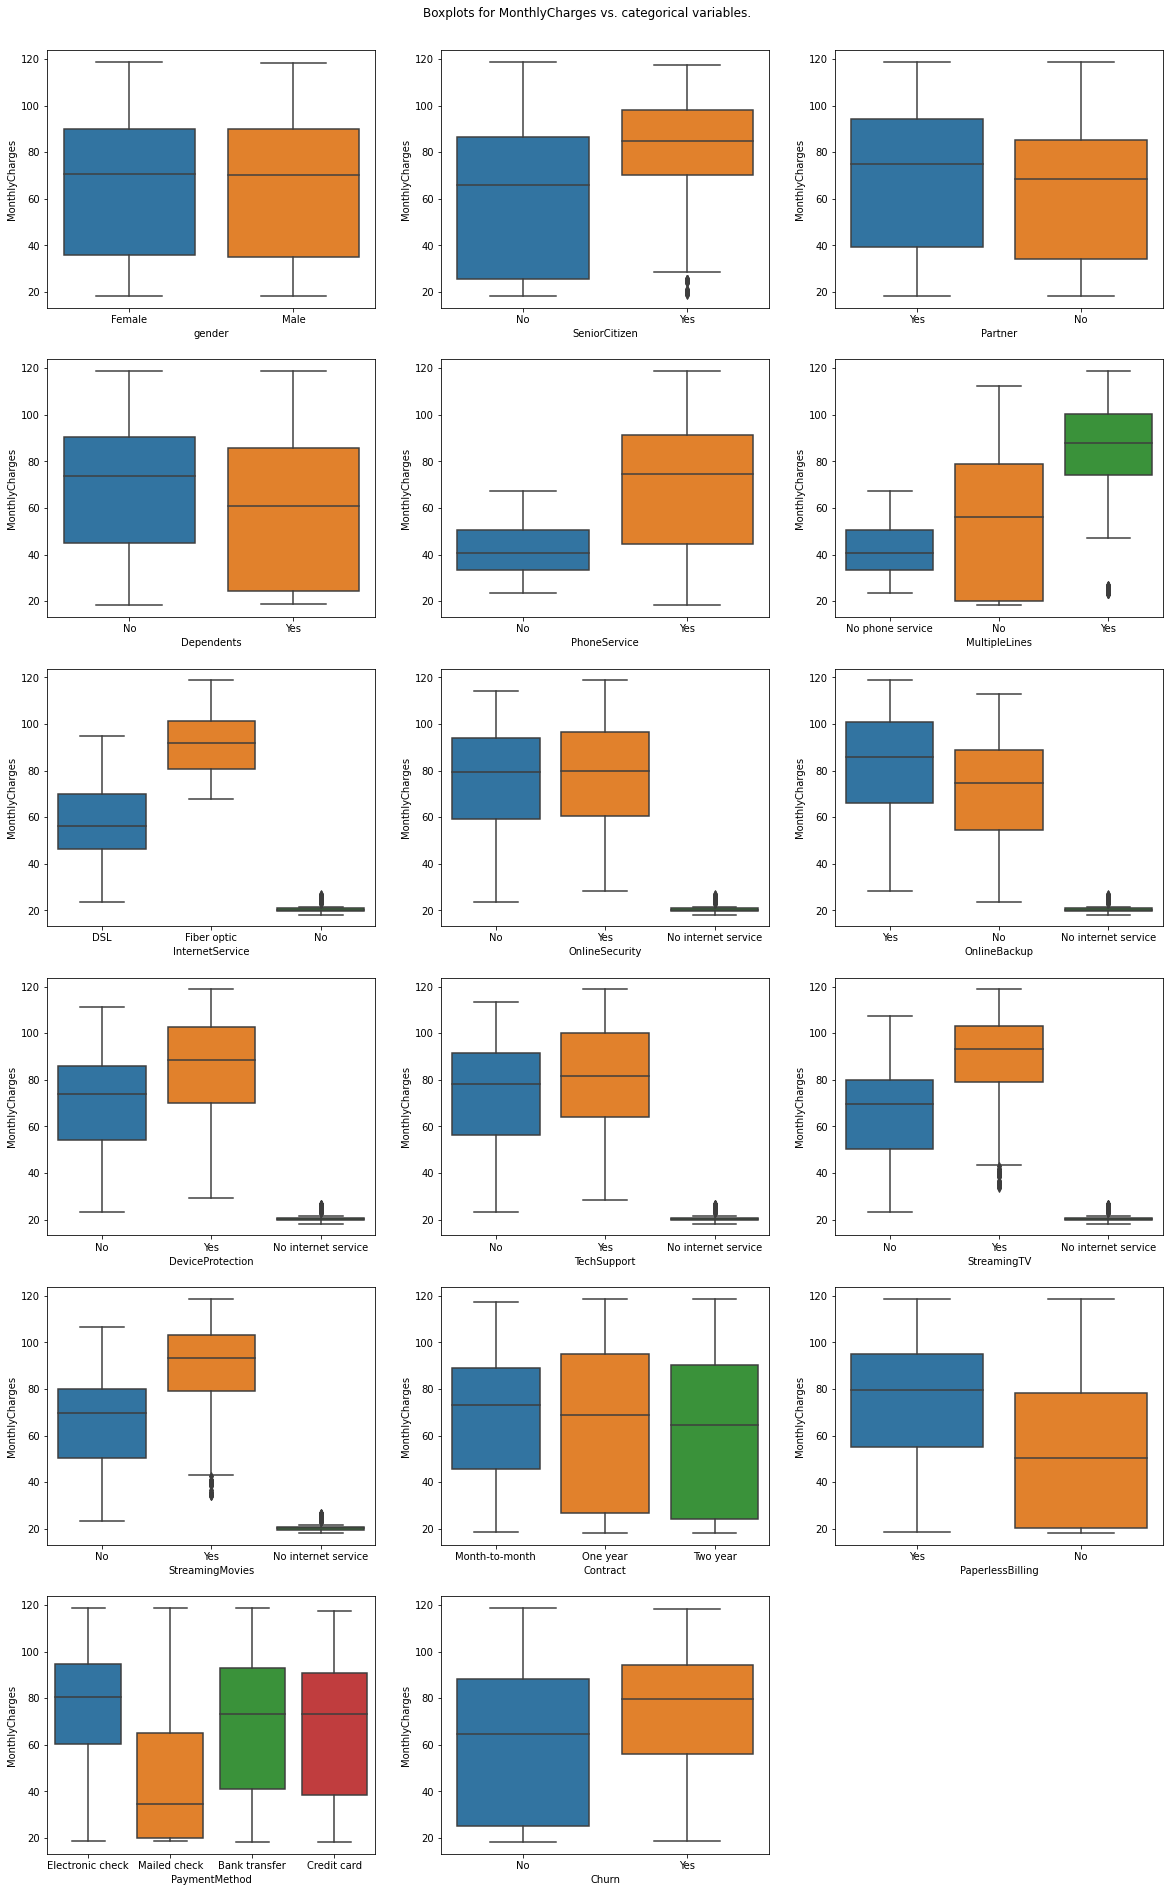

In [318]:
# Creating a figure and a set of subplots
fig, axs = plt.subplots(6, 3, figsize=(20, 30))
fig.subplots_adjust(top=0.96)
# Flattening the axs for easier indexing
axs = axs.flatten()

for i, feature in enumerate(data.select_dtypes(include=['object'])):
  sns.boxplot(data=data, x=feature, y='MonthlyCharges', ax=axs[i])
fig.delaxes(axs[-1])
fig.suptitle('Boxplots for MonthlyCharges vs. categorical variables.')
plt.show()

bservations:

- Senior citizens have higher MonthlyCharges.
- Customers with dependents tend to have a lower montly payment.
- The median of MonthlyCharges for the Month-to-month customers is higher than the rest of the contract types.
- Those who have paperlessbilling have a much higher median MonthlyCharges than those do not.
- Customers which method of payment is through mailed check haver very low monthly charges compared with the rest of the payment method types.
- Higher monthly charges are related with higher churn rates.

### 3.2.7 Boxplots for TotalCharges vs. categorical variables.

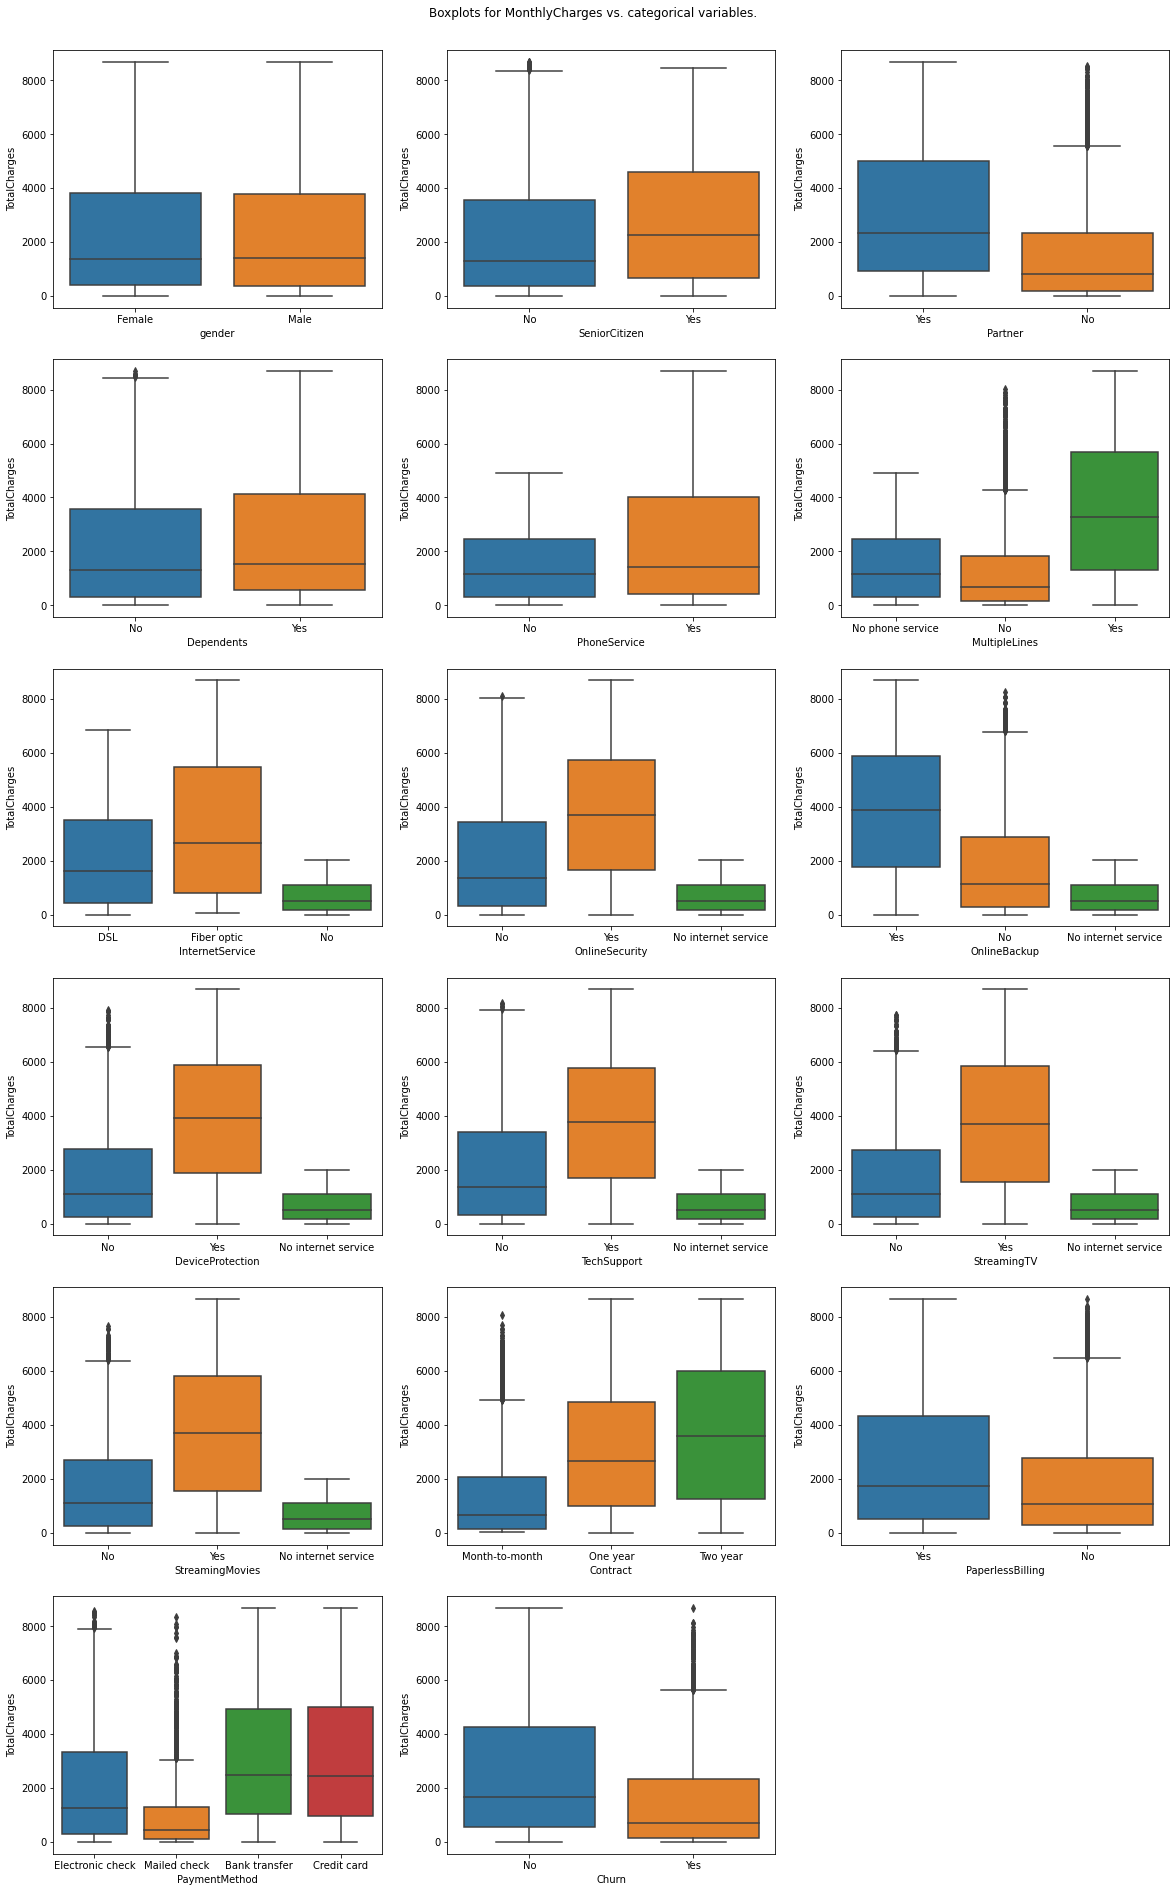

In [319]:
# Creating a figure and a set of subplots
fig, axs = plt.subplots(6, 3, figsize=(20, 30))
fig.subplots_adjust(top=0.96)
# Flattening the axs for easier indexing
axs = axs.flatten()

for i, feature in enumerate(data.select_dtypes(include=['object'])):
  sns.boxplot(data=data, x=feature, y='TotalCharges', ax=axs[i])
fig.delaxes(axs[-1])
fig.suptitle('Boxplots for MonthlyCharges vs. categorical variables.')
plt.show()

Observations:

- Most of the observations made in the previous set of plots (MonthlyCharges) are still true for the TotalCharges, however the median TotalCharges for the customers that left the company is less than those who stayed, which is understandable.

### 3.2.8 Countplots for Churn vs. categorical variables.

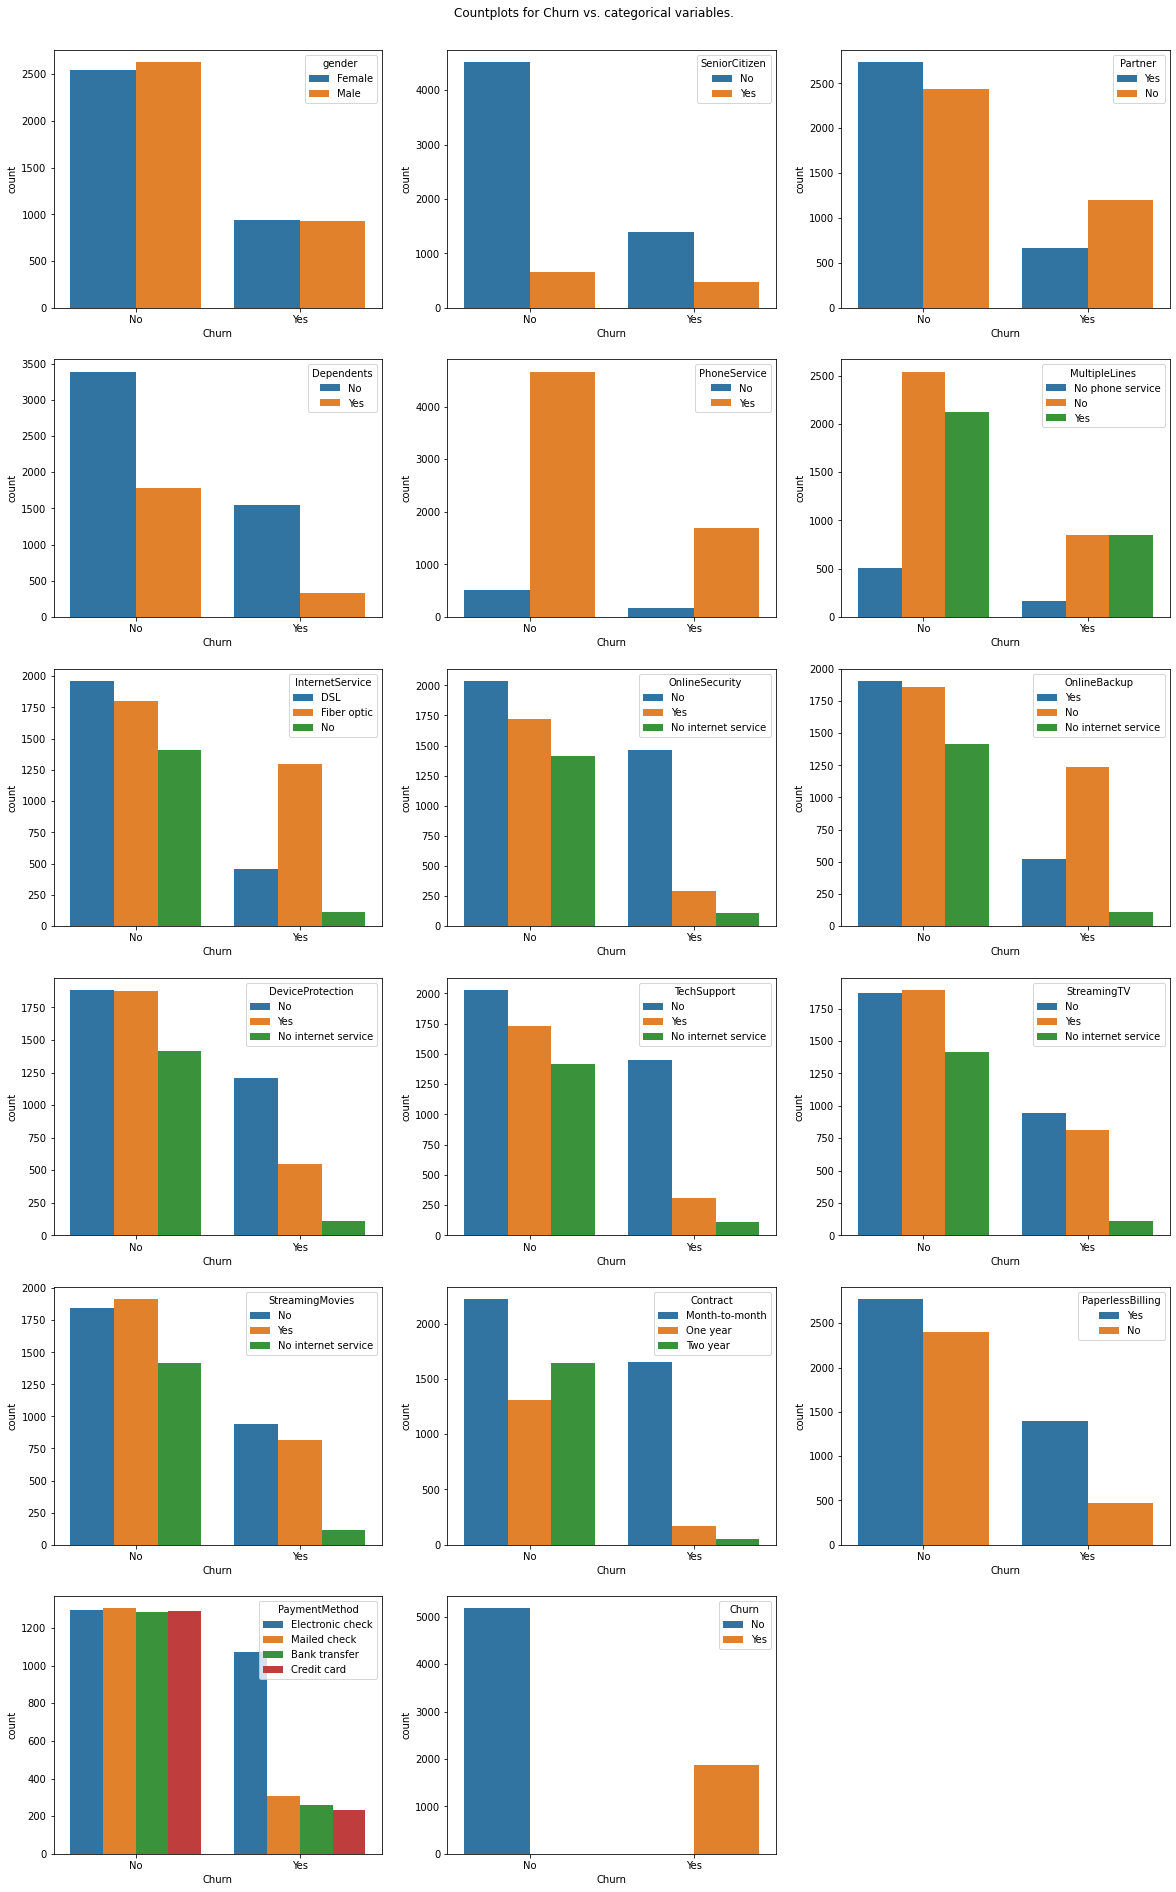

In [320]:
# Creating a figure and a set of subplots
fig, axs = plt.subplots(6, 3, figsize=(20, 30))
fig.subplots_adjust(top=0.96)
# Flattening the axs for easier indexing
axs = axs.flatten()

for i, feature in enumerate(data.select_dtypes(include=['object'])):
  sns.countplot(data=data, x='Churn', hue=feature, ax=axs[i])
fig.delaxes(axs[-1])
fig.suptitle('Countplots for Churn vs. categorical variables.')
plt.show()

This insights derived from the plots above are perhaps the most important information we can get in order to understand customer churn. The following observations can be made:

- Men and women are equally likely to leave the company.
- Having a partner reduces the chances of leaving the company, this might probably because they share services, so the need is doubled, and charges might get divided.
- Fiber optic customers are more likely to leave the company than DSL users.
- Having only security seems to be a feature shared among churners.
- Again month-to-month contrac customers are in high risk of leaving.
- Paying via electronic check is a good indicative of a potential churner.

# 4. Preprocessing

On this part of the project, the dataset is to be preprocessed and transformed in order to be suitable for the different machine learning models to be trained. In the previous sections (EDA), some preprocessing steps have been already performed/checked (those are marked with an asterisk in the list below):

- **1.** Acquire the dataset. (*)
- **2.** Import all the crucial libraries. (*)
- **3.** Import the dataset. (*)
- **4.** Identifying and handling the missing values. (*)
- **5.** Encoding the categorical data.
- **6.** Splitting the dataset.
- **7.** Feature scaling.

The following subsections would be dealing with points 5, 6 and 7.

## 4.1 Encoding the categorical data.

In this part the categorical features are to be transformed onto something the models can understand: numbers. However, by just converting them to numbers, i.e., integers, the models will then learn an ordinal representation of the features when there is not actual ordering for any of the features in the dataset. To avoid this, al categorical features are to be transformed to nominal(integers) then, a OneHot transformation is followed.

The target labels are also transformed from a text form to binary,i.e., (Yes/No)-->(1/0)

In [15]:
# Separating label from data DataFrame
X = data.drop(columns='Churn').copy(deep=True)
y = data['Churn'].copy(deep=True)

In [16]:
# Getting the categorical features names
categorical_features_names = list(X.select_dtypes(include='object').columns)
numerical_features = list(X.select_dtypes(exclude='object').columns)

# Pipeline for sequence of preprocessing steps
from_categorical_to_onehot = Pipeline([('categories', OrdinalEncoder()),
                                       ('onehot', OneHotEncoder(sparse=False, drop='if_binary'))])

# Creating a columntransformer to transform a subset of features (just categorical)
transformer = ColumnTransformer(transformers=[('from_categorical_to_onehot', from_categorical_to_onehot, categorical_features_names)],
                                               remainder='passthrough')

# Computing output feature names
output_feature_names = []
for i, feature in enumerate(categorical_features_names):
  n_unique = X.select_dtypes(include='object').describe().loc['unique'][i]
  if n_unique < 3:
    output_feature_names.append(feature)
  else:
    for j in range(1, n_unique + 1):
      output_feature_names.append(feature + '_' + str(j))
output_feature_names.extend(numerical_features)

# Encoding the target label
text_label_to_binary = LabelEncoder()
y_transformed = pd.Series(text_label_to_binary.fit_transform(y), name=y.name)

# Fitting and transfoming with the columntransformer
X_transformed = pd.DataFrame(transformer.fit_transform(X), columns=output_feature_names)

# Printing out a sample showing the transformed features
X_transformed.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines_1,MultipleLines_2,MultipleLines_3,InternetService_1,InternetService_2,InternetService_3,OnlineSecurity_1,OnlineSecurity_2,OnlineSecurity_3,OnlineBackup_1,OnlineBackup_2,OnlineBackup_3,DeviceProtection_1,DeviceProtection_2,DeviceProtection_3,TechSupport_1,TechSupport_2,TechSupport_3,StreamingTV_1,StreamingTV_2,StreamingTV_3,StreamingMovies_1,StreamingMovies_2,StreamingMovies_3,Contract_1,Contract_2,Contract_3,PaperlessBilling,PaymentMethod_1,PaymentMethod_2,PaymentMethod_3,PaymentMethod_4,tenure,MonthlyCharges,TotalCharges
0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,29.85,29.85
1,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,34.0,56.95,1889.50
2,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,53.85,108.15
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,45.0,42.30,1840.75
4,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,70.70,151.65


## 4.2 Splitting the dataset.

In this part, the dataset is to be split onto two parts: Training and Test. Some other approaches exists like splitting it onto three parts: Training, validation and test sets. However, the dataset is relatively small, for this reason a better approach is to perform a k-fold cross-validation in order to reduce the variance in performance.

The following code splits the dataset by giving the training set a total of 80% of the total examples(customers), and the test set with the rest(20%). Before splitting is made, a shuffling of the data is performed so that the examples are randomly selected. 

As we already know from previos analysis in the EDA section, we are dealing with an imbalanced dataset, i.e., the number of customers that left the company is less than those who stayed. Approximately 26% of customers have churn. In order to keep the same ratio on both splits, the splists are made in a stratified fashion.

In [17]:
# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y_transformed, test_size=0.20, random_state=0, stratify=y_transformed)

# Printing out the shapes of the datasets
print('Train shape is:', X_train.shape)
print('Test shape is:', X_test.shape)

Train shape is: (5634, 40)
Test shape is: (1409, 40)


## 4.3 Feature scaling.

Before feeding the data to the different classifiers, we need to make sure that
all the the numerical features (tenure, MonthlyCharges and TotalCharges) are in the same scale. For some models, there is also benefitial to make the the distribution of a feature look similar to a normal. For these reasons, a StandardScaler is to be used. This scaler applies a z-score normalization that shifts the data to have a mean of 0 and variance of 1.

Note: not all models are required to feed features in the same scale or to have a normal like distribution.

At this moment, no feature scaling is made, however it will be applied within the context of a pipeline model which is to be constructed in the sections to come.

# 5. Model Selection

In this part of the project, a model selection is to be applied. Five different classifiers are to be trained and the model with the highest validation metric is to be chosen. The classifiers to train are:

- Logistic Regression.
- Decision Tree.
- Random Forest.
- Support Vector Machine.
- XG Boost.

For those models were the numerical features are benefited from being in the same scale with equal mean and variance are normalized using a StandardScaler approach. For those models where a normalization process is needed, a pipeline is constructed in order to avoid data leakage in cross-validation (in all cases metrics like mean and standard deviation are stimated just from the training portion or training split). 

Below is the code for constructing the scaler pipeline (onehot features are left untouched), followed by the model instances.

In [18]:
# Standardizing features by removing the mean and scaling to unit variance (just numerical features)
scaler = ColumnTransformer(transformers=[('z-score', StandardScaler(), numerical_features)], remainder='passthrough')

In [19]:
# Classifiers
classifiers = {'Logistic Regression': make_pipeline(scaler, LogisticRegression()),
               'Decision Tree': DecisionTreeClassifier(),
               'Random Forest': RandomForestClassifier(),
               'SVM': make_pipeline(scaler, SVC()),
               'XG Boost': XGBClassifier()
               }

## 5.2 Training, Hyperparameter Tuning and Grid Search Cross Validation

One thing to note for the Grid Search is that during the k-fold cross validation, the data is split in a stratified fashion, i.e, the folds are constructed by preserving the percentage of samples for each class. For all models and configurations same folds are used.

In [20]:
# Hyperparameters to optimize
hyperparameter_space = {'Logistic Regression': [{'logisticregression__penalty': ['l2'],
                                                 'logisticregression__C': [1.0, 0.1, 0.01],
                                                 'logisticregression__class_weight': ['balanced']},
                                                
                                                {'logisticregression__penalty': ['none'],
                                                 'logisticregression__class_weight': ['balanced']},
                                                
                                                {'logisticregression__solver': ['liblinear'],
                                                 'logisticregression__penalty': ['l1', 'l2'],
                                                 'logisticregression__C': [1.0, 0.1, 0.01],
                                                 'logisticregression__class_weight': ['balanced']}],
                        
                        'Decision Tree': [{'criterion': ['gini', 'entropy'],
                                           'max_depth': np.arange(2, 10),
                                           'max_features': ['auto', 'sqrt', 'log2', None],
                                           'min_samples_split': [2, 5, 10, 20],
                                           'class_weight': ['balanced']}],

                        'Random Forest': [{'criterion': ['gini', 'entropy'],
                                           'max_depth': np.arange(2, 10),
                                           'n_estimators': [5, 10, 20, 50, 100],
                                           'min_samples_split': [2, 5, 10, 20],
                                           'class_weight': ['balanced']}],
                        
                        'SVM': [{'svc__C': np.linspace(1.0, 2.0, 6),
                                 'svc__kernel': ['linear', 'poly', 'rbf'],
                                 'svc__class_weight': ['balanced'],
                                 'svc__degree': [2, 3]}],
                        
                        'XG Boost': [{'class_weight': ['balanced'],
                                      'max_depth': np.arange(2, 5),
                                      'n_estimators': [10, 20, 50, 100]
                                      }]
                        }

In [21]:
def hyperparameter_tuning_cv(estimators, param_grid, scoring, X, y, cv=5, refit=True):
  # Creating a container to get the the best classifiers and cross validation reports.
  grid_search_output = {clf: {} for clf in classifiers}
  for clf in classifiers:

    print('Grid Search for:', clf)

    # Perform a 5-fold cross validation for every configuration in the hyperparameter_space
    grid_search_cv = GridSearchCV(estimator=estimators[clf],
                                  param_grid = param_grid[clf],
                                  scoring=scoring,
                                  cv=cv,
                                  return_train_score=True,
                                  refit=True,
                                  verbose=3,
                                  n_jobs=-1)
    
    # Fitting the model accros folds
    grid_search_output[clf] = grid_search_cv.fit(X, y)

  return grid_search_output

Since the nature of our dataset is imbalanced, a good measure in such cases is the F1-Score or just F-Score, however, such measure gives the same weight for False Positives(FP) as for False Negative (FN). In this case, this is not completely appropriate since a FN could have much more impact in company revenue than a FP. For this reason the metric selected is the $F_β$ score with a $β=2$, i.e., the F2-Score.

In [22]:
# First we select our scoring funcion to be F2-Score
f2_score = make_scorer(fbeta_score, beta=2)

In [23]:
# Running the grid search for hyperparameter tuning with 5-fold cross validation
grid_search_output = hyperparameter_tuning_cv(estimators=classifiers, param_grid=hyperparameter_space,scoring=f2_score, X=X_train, y=y_train, cv=5)

Grid Search for: Logistic Regression
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Grid Search for: Decision Tree
Fitting 5 folds for each of 256 candidates, totalling 1280 fits
Grid Search for: Random Forest
Fitting 5 folds for each of 320 candidates, totalling 1600 fits
Grid Search for: SVM
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Grid Search for: XG Boost
Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [24]:
# Saving grid_search_output to disk (optional)
grid_search_to_file = open('gridsearch.sav', 'wb')
pickle.dump(grid_search_output, grid_search_to_file)
grid_search_to_file.close()

In [29]:
# load the model from disk
grid_search_output = pickle.load(open('gridsearch.sav', 'rb'))

## 5.3 Looking for overfitting: Mean training scores vs. mean validation scores

Before moving forward with selecting the best model, we should verify that our trained models is not overfitting the training splits. Even if we get a higher validation score, if a high difference between the performance in training and validation is found, the results tend to be less confident, i.e., it might behave very poorly on unseen data since it has learned the noise on the training data.

Below a report about the means for training and validation for the 5-fold cross validation exercise is shown. Just the best estimators are considered.

In [ ]:
# Creating report on a pandas dataframe
columns_to_filter = ['mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score']  

training_vs_validation_report = pd.DataFrame(columns=columns_to_filter)

for clf in classifiers:
  temp_row = pd.DataFrame(grid_search_output[clf].cv_results_).iloc[grid_search_output[clf].best_index_]
    
  # Adding row to dataframe
  training_vs_validation_report.loc[clf, columns_to_filter] = temp_row

# Output the report
training_vs_validation_report

,mean_train_score,std_train_score,mean_test_score,std_test_score
Logistic Regression,0.72466,0.00502711,0.719093,0.0226338
Decision Tree,0.727275,0.0134499,0.714764,0.0154759
Random Forest,0.736085,0.00778334,0.725454,0.0158456
SVM,0.720131,0.00355627,0.720089,0.0142873
XG Boost,0.595087,0.00420724,0.550611,0.0269865


In [30]:
# Creating report on a pandas dataframe
columns_to_filter = ['mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score']  

training_vs_validation_report = pd.DataFrame(columns=columns_to_filter)

for clf in classifiers:
  temp_row = pd.DataFrame(grid_search_output[clf].cv_results_).iloc[grid_search_output[clf].best_index_]
    
  # Adding row to dataframe
  training_vs_validation_report.loc[clf, columns_to_filter] = temp_row

# Output the report
training_vs_validation_report

,mean_train_score,std_train_score,mean_test_score,std_test_score
Logistic Regression,0.72466,0.00502711,0.719093,0.0226338
Decision Tree,0.727275,0.0134499,0.714764,0.0154759
Random Forest,0.736085,0.00778334,0.725454,0.0158456
SVM,0.720131,0.00355627,0.720089,0.0142873
XG Boost,0.595087,0.00420724,0.550611,0.0269865


From the report above, we can see that in general the performance (in terms of the F2-Score) in the train and validation data are very similar for all models. This give us certainty that at least the models could be generalizable. In the next subsection the models are validated on the test partition in order to select the model with the best performance among the 5 candidates.

## 5.4 Model validation on test partition

In this part of the problem, one classifier is to be chosen from the trained models. The criteria for choosing a model is the F2-Score, the higher the better. The data used is the data set, and has never seen before, this allows to have a better estimate for the real performance once the model is deployed in production, i.e., an unbiased estimate.

Along with the metric reports for every classifier, a baseline model is also included in the report. This baseline model is a very simple "model" that always predict the positive class (the minority in this case), in order to have a perfect recall, i.e., saying that all customers are likely to leave.This might seem not very practical, however it gives a good starting point as to assess the trained model capacity of learning useful patterns from the data.

Below you can the final report.

In [26]:
  # Computing metrics for a classifier
  def metrics_per_classifier(metric_function, metrics, y, y_pred):
    temp_metrics = []
    for metric in metrics:
      if metric != 'f2-score':
        temp_metrics.append(round(metric_function[metric](y, y_pred), 2))
      else:
        temp_metrics.append(round(metric_function[metric](y, y_pred, beta=2), 2))
    
    return temp_metrics

In [27]:
def model_validation_report(estimators, X, y, metrics):

  # Dictionary to map metrics with its function
  metric_function = {'precision': precision_score, 'recall': recall_score, 'f2-score': fbeta_score, 'accuracy': accuracy_score}

  # Container for final report
  report = pd.DataFrame(columns=metrics)

  # Setting baseline metrics
  y_baseline = np.ones(len(y))
  baseline_metrics = metrics_per_classifier(metric_function, metrics, y, y_baseline)
  report.loc['Baseline', metrics] = baseline_metrics

  for clf in estimators:
    # Predicting the labels
    y_pred = grid_search_output[clf].best_estimator_.predict(X)

    # Computing metrics for clf
    temp_metrics = metrics_per_classifier(metric_function, metrics, y, y_pred)

    # Appending row to report
    report.loc[clf, metrics] = temp_metrics

  return report

In [ ]:
# Printing out te report metrics
metrics = ['precision', 'recall', 'f2-score', 'accuracy']
model_validation_report(classifiers, X_test, y_test, metrics)

,precision,recall,f2-score,accuracy
Baseline,0.27,1,0.64,0.27
Logistic Regression,0.52,0.81,0.73,0.75
Decision Tree,0.54,0.74,0.69,0.77
Random Forest,0.51,0.78,0.71,0.75
SVM,0.47,0.82,0.71,0.7
XG Boost,0.68,0.52,0.55,0.81


From the report above, we can see that the best model as per the 'f2-score' is the 'Logistic Regression' with a f2-score of 0.73. It is worth noticing that all models but 'XG Boost' outperformed the simple baseline in this metric. This give us a first result that the models have at least practical significance. In the next subsection a k-fold cross validation paired t-Test is performed in order to compare pairs of classifiers performances.

## 5.5 Statistical Test

Here, a k-fold cross validation paired t-Test is performed for each pair of classifiers, a total of 5x5 tests are carried out. The significance level $\alpha$ is set to 0.05 (5\%). Resuls are shown in a heat map below. Null hypothesis is that both pair of classifiers have the same mean for the error rates (in this case the f2-score). The following cases are derived:

- Orange cells represent cases where the null hypothesis is accepted. 
- Blue cells represent cases where null is rejected.

**Note:** To increase confidence on the statistical test, a total of 100 scores are computed, by performing 20x(5-fold cross validation) experiments. Each of the 20 runs have a different data split configuration.

In [197]:
# Function to compute a t-test between two series
def t_test(scores_model_1, scores_model_2, alpha):
  if np.all(scores_model_1 == scores_model_2):
    test_result = 1
  else:
    # Computing the ith difference in performance 
    pi = scores_model_1 - scores_model_2

    # Computing mean and sample variance
    m = pi.mean()
    s2 = pi.var(ddof=1)

    # Getting the t statistic
    computed_t = ((np.sqrt(len(scores_model_1))) * m) / np.sqrt(s2)

    # Getting the t value for a ppf at alpha
    t_value = t.ppf(q=1 - (alpha/2), df=len(scores_model_1)-1)
    test_result = (t_value > abs(computed_t)) * 1

  return test_result

In [58]:
# Getting the best parameters from grid_search_output for each model
best_parameters = {clf:{x:[y] for x, y in grid_search_output[clf].best_params_.items()} for clf in classifiers}

In [157]:
# Function to get the KxL scores for using in the paired t-Test
def paired_t_test_scores(estimators, param_grid, scoring, X, y, K, L):

  # Getting column names
  column_names = ['split' + str(i) + '_test_score' for i in range(K)]

  # Creating cross validation reports.
  scores_for_t_test = {clf: {} for clf in classifiers}
  aggregated_scores = {clf: pd.DataFrame(columns=column_names) for clf in classifiers}

  for l in range(L):

    # Shuffle the data at each run (l) to get different splits
    cv_splitter = KFold(n_splits=K, shuffle=True, random_state=l)
    for clf in classifiers:

      # Perform a 5-fold cross validation for every configuration in the hyperparameter_space
      grid_search_cv = GridSearchCV(estimator=estimators[clf],
                                    param_grid = param_grid[clf],
                                    scoring=scoring,
                                    cv=cv_splitter,
                                    verbose=3,
                                    n_jobs=-1)
      
      # Fitting the model accros folds
      scores_for_t_test[clf][l] = grid_search_cv.fit(X, y)
    
      # Adding scores row to aggregated_scores
      temp_dataframe = pd.DataFrame(scores_for_t_test[clf][l].cv_results_)[column_names]
      aggregated_scores[clf] = pd.concat((aggregated_scores[clf],temp_dataframe))
  
  # Getting the evaluation scores in a 1D numpy array
  aggregated_scores = {clf: aggregated_scores[clf].to_numpy().flatten() for clf in classifiers} 

  return aggregated_scores

In [ ]:
# Getting the scores for the paired t-Test
aggregated_scores = paired_t_test_scores(classifiers, best_parameters, scoring=f2_score, X=X_train, y=y_train, K=5, L=20)

In [192]:
# Function to compute the paired_t_test_matrix
def t_test_matrix(scores, alpha):

    paired_t_test_results = []

    for clf_1 in scores:
      # Creating a row for the final results
      temp_paired_t_test_results = []
      for clf_2 in scores:

        # Getting the t-test result
        temp_paired_t_test_results.append(t_test(scores[clf_1], scores[clf_2], alpha))
      
      # Appending row to list
      paired_t_test_results.append(temp_paired_t_test_results)

    # Creating a pandas Dataframe with columns and indexes as the experiment_names
    paired_t_test_matrix = pd.DataFrame(paired_t_test_results, columns=scores.keys(), index=scores.keys()) 

    return paired_t_test_matrix

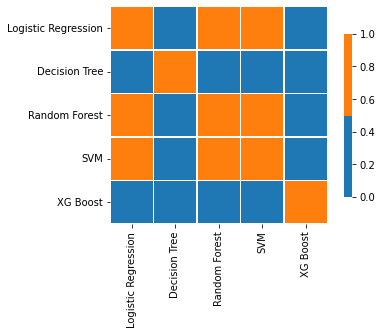

In [205]:
# Defining the cmap
cmap = sns.color_palette('tab10', n_colors=2)
sns.heatmap(t_test_matrix(aggregated_scores, alpha=0.05), cmap=cmap, vmax=1.0, square=True, linewidths=0.5, annot=False, cbar_kws={"shrink": 0.75})
plt.show()

From the heatmap above, we can see that we failed to reject the null hypothesis for the any pair involving: 'Logistic Regression', 'SVM' or 'Random Forest'. For the 'f2-score' measured it was not observe a statitstical difference in performance at an $\alpha=0.05$. However, from the already trained models, the 'Logistic Regression' is chosen because it is easier to train, has the highest 'f2-score', is easily interpretable since it natively gives the probability of an event occurring. Such probability can be used to better select the retention strategy to be given for a particular customer.

## 5.6 Moving the thresholds

For those classification problems that have class imbalance (like the one at hand), the default threshold can result in poor performance. As such, a simple and straightforward approach to improving the performance of a classifier that predicts probabilities on an imbalanced classification problem is to tune the threshold used to map probabilities to class labels.



In [264]:
def moving_threshold_plot(X, y, split_name):
  # Define probability thresholds to use, between 0 and 1
  probability_thresholds = np.linspace(0, 1, num=100)

  f2_scores = []
  predicted_probabilities = grid_search_output['Logistic Regression'].predict_proba(X)

  # Just keep probabilities for the positive class
  predicted_probabilities = predicted_probabilities[:, 1]

  for p in probability_thresholds:
    y_pred = (predicted_probabilities > p) * 1
    f2_scores.append(fbeta_score(y, y_pred, beta=2))
  
  # Plotting the thresholds vs f2-scores
  plt.plot(probability_thresholds, f2_scores, label=split_name)
  plt.title('Probability Threshold vs. f2_scores:' + split_name)
  plt.xlabel('Probability Threshold')
  plt.ylabel('f2-score')

  return y_pred

def get_optimal_threshold(X, y):
  # Define probability thresholds to use, between 0 and 1
  probability_thresholds = np.linspace(0, 1, num=100)

  f2_scores = []
  predicted_probabilities = grid_search_output['Logistic Regression'].predict_proba(X)

  # Just keep probabilities for the positive class
  predicted_probabilities = predicted_probabilities[:, 1]

  for p in probability_thresholds:
    y_pred = (predicted_probabilities > p) * 1
    f2_scores.append(fbeta_score(y, y_pred, beta=2))

  # Argmax
  f2_scores = np.array(f2_scores)
  index = f2_scores.argmax()

  return f2_scores[index], probability_thresholds[index]

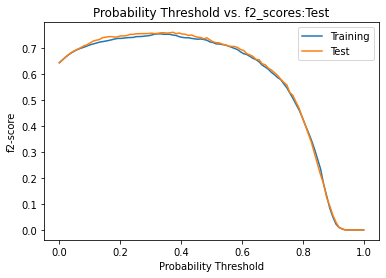

In [261]:
# Plotting the thresholds vs f2-scores
moving_threshold_plot(X_train, y_train, 'Training')
moving_threshold_plot(X_test, y_test, 'Test')
plt.legend()
plt.show()

In [272]:
# Printing the max f2_scores and optimal thresholds
print('Training')
print('(max_f2_score, optimal_threshold)=', get_optimal_threshold(X_train, y_train))
print()
print('Test')
print('(max_f2_score, optimal_threshold)=', get_optimal_threshold(X_test, y_test))

Training
(max_f2_score, optimal_threshold)= (0.7545823729557679, 0.33333333333333337)

Test
(max_f2_score, optimal_threshold)= (0.7609185051778479, 0.37373737373737376)


# 6 Final Model

By looking at the plots above it is clear that an optimal threshold for optimizing the problem is around 0.35. It should be also estimated during cross validation to avoid methodological errors or even over optimistic results. However, by looking at the curves for both the training and the test sets, it seems that such threshold is something inherent to the process itself.

Again, this should be optimized in a cross validation setting and not along with the test set. For now, a threshold of 0.35 is to be selected since it seems natural to me.

## 6.1 Final Model - Scores

In [280]:
# First we compute the labels with a threshold of 0.35.
y_pred = (grid_search_output['Logistic Regression'].predict_proba(X_test)[:, 1] > 0.35) * 1

# Printing the classification report (here the f1-score is not our metric).
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.60      0.74      1035
           1       0.45      0.91      0.60       374

    accuracy                           0.68      1409
   macro avg       0.70      0.76      0.67      1409
weighted avg       0.82      0.68      0.70      1409



From the above classification report we can see a good improvement in recall (0.91) for the positive class as compared with the previous score (0.81, subsection 5.4). Now our model has a very high recall which is something desirable as the expense of reducing a bit the precision, however, from a company perspective this is much more important.

In [284]:
# Printing the f2-score
print('f2-score:', round(fbeta_score(y_test, y_pred, beta=2), 2))

f2-score: 0.76


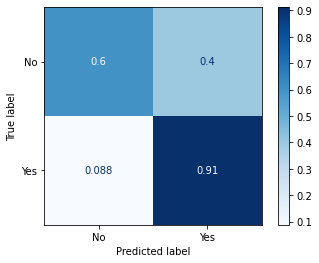

In [291]:
# Plotting the confusion matrix
labels_names = ['No', 'Yes'] 
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()

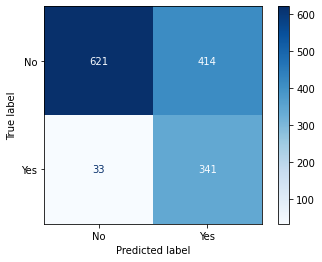

In [292]:
# Plotting the confusion matrix
labels_names = ['No', 'Yes'] 
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# 7. Conclusion

From a company perspective, customer churn is a very importan task to solve. Machine learning models allow us to learn patterns and behaviors from the data in order to solve this problem. 

In this exercise a Logistic Regression model was obtained with very good metric results. It can potentially be used for customer churn prediction on the Telco company. It focuses in what is more important to the company, i.e., identify a possible churner. However, the job is not done, is responsibility of the company to take advantage of this informantion and act accordingly.